# Draft 2 - Dissertation

Sentiment analysis to understand the effect of meme community on the stock market. This paper studies how r/wallstreetbets have an impact on the stock market and how some companies are discussed more due to the relevance/popularity of the company in the general space.

# Importing Libraries

TODO: ML libraries to be added

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import yfinance as yf
import openai
from os import getenv
from dotenv import load_dotenv
import openai
import time
from datetime import datetime, timedelta

# Read the symbols into a variable 

and search any specific symbol, and/or add "$" to a paticular symbol

In [3]:
symbols = pd.read_csv('symbols.csv')
symbols.head(3)

,Symbol,Dollar_Symbol,Name
0,$A,$A,Agilent Technologies Inc. Common Stock
1,AA,$AA,Alcoa Corporation Common Stock
2,AAC,$AAC,Ares Acquisition Corporation Class A Ordinary ...


In [4]:
#search for a specific symbol
sym = '$NOW'
print(symbols.loc[symbols['Symbol'] == sym])

     Symbol Dollar_Symbol                          Name
2328   $NOW          $NOW  ServiceNow Inc. Common Stock


In [ ]:
#add a "$" to a specific Symbol column in the symbols df from the change variable matching the Symbols column
change = 'NEXT'
symbols.loc[symbols['Symbol'] == change, 'Symbol'] = '$' + change
print(symbols.loc[symbols['Symbol'] == '$'+change])
#save the symbols df in the csv file
symbols.to_csv('symbols.csv', index=False)

# Cleaning the data - Remove duplicates


In [4]:
def remove_duplicates(input_file, output_file):
    try:
        with open(input_file, 'r') as f:
            sentences = f.readlines()

        # Remove duplicates while preserving the order
        unique_sentences = list(dict.fromkeys(sentences))

        with open(output_file, 'w') as f:
            f.writelines(unique_sentences)

        print("Duplicates removed successfully and saved to", output_file)
    except FileNotFoundError:
        print("File not found. Please check the input file path.")
    except Exception as e:
        print("An error occurred:", e)

In [5]:
# File inputs
input_file = 'raw_txt/hot.txt'
output_file = 'clean_txt/clean_hot.txt'

remove_duplicates(input_file, output_file)

Duplicates removed successfully and saved to clean_txt/clean_hot.txt


In [6]:
# File inputs
input_file = 'raw_txt/new.txt'
output_file = 'clean_txt/clean_new.txt'

remove_duplicates(input_file, output_file)

Duplicates removed successfully and saved to clean_txt/clean_new.txt


# Read the hot file into a variable

In [7]:
#import the hot text file to a list
hot = open('clean_txt/clean_hot.txt').read().split('\n')
#count the number of items in the list
len(hot)

3213

In [8]:
new = open('clean_txt/clean_new.txt').read().split('\n')
len(new)

3377

# Make the lines into a dataframe with dates and text

this is done so it is easy to get the dates with the sentences

In [9]:
def make_dataframe(file_name):
    # Initialize a list to store the DataFrame rows
    rows = []

    # Open the file for reading
    with open(file_name, 'r') as file:
        current_date = None

        # Read the file line by line
        for line in file:
            # Check if the line matches the date format
            match = re.search(r'[-]+(\d{4}-\d{2}-\d{2})', line)
            if match:
                # Extract the date in the format "YYYY-MM-DD"
                current_date = match.group(1) # Only extract the date part without dashes

            else:
                # If the line is not a date, add it as a row in the DataFrame
                if current_date is not None: # Avoid adding rows without an associated date
                    rows.append({'date': current_date, 'text': line.strip()})

    # Create a DataFrame from the list of rows
    df = pd.DataFrame(rows, columns=['date', 'text'])

    # Print the DataFrame to see the results
    print(df)

    # Return the DataFrame
    return df

In [87]:
hot_df = make_dataframe('clean_txt/clean_hot.txt')

            date                                               text
0     2023-03-16       What Are Your Moves Tomorrow, March 16, 2023
1     2023-03-16  Most Anticipated Earnings Releases for the wee...
2     2023-03-16          Eggon says “GME go up” after earnings. ⬆️
3     2023-03-16  Goldman Sachs: 99% of borrowers have a mortgag...
4     2023-03-16                            Who would have thought?
...          ...                                                ...
3158  2023-08-04                       When the IRS comes after you
3159  2023-08-04  How do people lose their entire account on opt...
3160  2023-08-04                  Better Option Strategies, Advice?
3161  2023-08-04                                 Whats up with $TGT
3162  2023-08-04  You do NOT have to buy the shares when exercis...

[3163 rows x 2 columns]


In [92]:
new_df[new_df['text'] == ""]

,date,text
1604,2023-06-25,


In [11]:
new_df = make_dataframe('clean_txt/clean_new.txt')

            date                                               text
0     2023-03-16  Wrinkle-brain Plays (Mathematically derived op...
1     2023-03-16     SONY Stock Forecast, Price & News (Sony Group)
2     2023-03-16                    Credit Suisse = Lehman Brothers
3     2023-03-16  Credit Suisse to borrow up to about $54 billio...
4     2023-03-16     "you met me at a very strange time in my life"
...          ...                                                ...
3323  2023-08-04                         Why did you start trading?
3324  2023-08-04  MCRB - possibly groundbreaking microbiome trea...
3325  2023-08-04           Learned what early assignment is today 🥲
3326  2023-08-04     $250K YOLO on Allogene $ALLO High SI right now
3327  2023-08-04                  Better Option Strategies, Advice?

[3328 rows x 2 columns]


In [12]:
#write hot_df into a csv file named hot_df with no index
hot_df.to_csv('text_df/hot_df.csv', index=False)
new_df.to_csv('text_df/new_df.csv', index=False)

In [94]:
hot_df = pd.read_csv('text_df/hot_df.csv')
print(f"Hot length: {len(hot_ticker)}")
new_df = pd.read_csv('text_df/new_df.csv')
print(f"New length: {len(new_ticker)}")

Hot length: 3163
New length: 3327


# Find the tickers in each sentence

In [13]:
def symbol_matches(sentence, symbol_list):
    matches = []
    for symbol in symbol_list:
        if pd.notna(symbol):  # Skip NaN values in the symbol_list
            pattern = r"\b" + re.escape(str(symbol)) + r"\b"
            if re.search(pattern, sentence):
                matches.append(symbol)
    return matches

def find_matches(hot_df, symbols):
    # List to store the results
    results = []

    # Iterate through each row in the DataFrame
    for index, row in hot_df.iterrows():
        date = row['date']
        sentence = row['text']

        # Find matches for each sentence with "Symbol" and "Dollar_Symbol" columns
        matches_symbols = symbol_matches(sentence, symbols['Symbol'].tolist())
        matches_dollar_symbols = symbol_matches(sentence, symbols['Dollar_Symbol'].tolist())
        all_matches = matches_symbols + matches_dollar_symbols

        # If all_matches is empty then input "S&P"
        if not all_matches:
            all_matches = ['S&P']

        # Concatenate the matches into a single string
        ticker_string = ', '.join(all_matches)

        # Append the results to the list
        results.append((date, sentence, ticker_string))

    # Create a new DataFrame to store the results
    tickers = pd.DataFrame(results, columns=["date", "text", "ticker"])

    # Print the result DataFrame
    print(tickers)

    # Return the result DataFrame  
    return tickers


In [14]:
hot_ticker = find_matches(hot_df,symbols)

            date                                               text ticker
0     2023-03-16       What Are Your Moves Tomorrow, March 16, 2023    S&P
1     2023-03-16  Most Anticipated Earnings Releases for the wee...    S&P
2     2023-03-16          Eggon says “GME go up” after earnings. ⬆️    GME
3     2023-03-16  Goldman Sachs: 99% of borrowers have a mortgag...    S&P
4     2023-03-16                            Who would have thought?    S&P
...          ...                                                ...    ...
3159  2023-08-04                       When the IRS comes after you    IRS
3160  2023-08-04  How do people lose their entire account on opt...    S&P
3161  2023-08-04                  Better Option Strategies, Advice?    S&P
3162  2023-08-04                                 Whats up with $TGT    TGT
3163  2023-08-04  You do NOT have to buy the shares when exercis...    S&P

[3164 rows x 3 columns]


In [15]:
new_ticker = find_matches(new_df,symbols)

            date                                               text ticker
0     2023-03-16  Wrinkle-brain Plays (Mathematically derived op...    S&P
1     2023-03-16     SONY Stock Forecast, Price & News (Sony Group)   SONY
2     2023-03-16                    Credit Suisse = Lehman Brothers    S&P
3     2023-03-16  Credit Suisse to borrow up to about $54 billio...    S&P
4     2023-03-16     "you met me at a very strange time in my life"    S&P
...          ...                                                ...    ...
3323  2023-08-04                         Why did you start trading?    S&P
3324  2023-08-04  MCRB - possibly groundbreaking microbiome trea...   MCRB
3325  2023-08-04           Learned what early assignment is today 🥲    S&P
3326  2023-08-04     $250K YOLO on Allogene $ALLO High SI right now   ALLO
3327  2023-08-04                  Better Option Strategies, Advice?    S&P

[3328 rows x 3 columns]


In [16]:
# Filter the DataFrame to exclude rows with 'S&P' in the 'Ticker' column
non_sp_sentences = hot_ticker[hot_ticker['ticker'] != 'S&P']
len(non_sp_sentences)


671

In [17]:
sp_sentences = hot_ticker[hot_ticker['ticker'] == 'S&P']
len(sp_sentences)

2493

In [18]:
#write hot_ticker to a csv with no index
hot_ticker.to_csv('text_df/hot_ticker.csv', index=False)
new_ticker.to_csv('text_df/new_ticker.csv', index=False)

In [93]:
#read hot_ticker csv to a variable name hot_ticker
hot_ticker = pd.read_csv('text_df/hot_ticker.csv')
print(f"Hot length: {len(hot_ticker)}")
new_ticker = pd.read_csv('text_df/new_ticker.csv')
print(f"New length: {len(new_ticker)}")

Hot length: 3163
New length: 3327


# FINBERT

In [89]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="ProsusAI/finbert")

In [90]:
def finbert_sentiments(df,pipe=pipe):
    # Create an empty list to store the rows
    rows = []
    
    # Iterate through the DataFrame rows
    for index, row in df.iterrows():
        date = row['date']
        text = row['text']
        ticker = row['ticker']

        # If text is a string, convert it to a list with one element
        if isinstance(text, str):
            sentences = [text]
        
        # Process the sentences through the pipeline
        results = pipe(sentences)
        
        # Iterate through the sentences and results to create rows
        for sentence, result in zip(sentences, results):
            rows.append((date, sentence, ticker, result['label'], result['score']))
            
    # Create a DataFrame from the rows
    finbert_sentiment = pd.DataFrame(rows, columns=['date', 'text', 'ticker', 'label', 'score'])
    
    return finbert_sentiment


In [91]:
hot_finbert = finbert_sentiments(hot_ticker)
print(hot_finbert.head(5))
print(f"Hot Finbert length: {len(hot_ticker)}")

         date                                               text ticker  \
0  2023-03-16       What Are Your Moves Tomorrow, March 16, 2023    S&P   
1  2023-03-16  Most Anticipated Earnings Releases for the wee...    S&P   
2  2023-03-16          Eggon says “GME go up” after earnings. ⬆️    GME   
3  2023-03-16  Goldman Sachs: 99% of borrowers have a mortgag...    S&P   
4  2023-03-16                            Who would have thought?    S&P   

      label     score  
0   neutral  0.901751  
1   neutral  0.846477  
2   neutral  0.465376  
3  negative  0.776503  
4   neutral  0.783594  
Hot Finbert length: 3163


In [95]:
new_finbert = finbert_sentiments(new_ticker)
print(new_finbert.head(5))
print(f"New Finbert length: {len(new_ticker)}")

         date                                               text ticker  \
0  2023-03-16  Wrinkle-brain Plays (Mathematically derived op...    S&P   
1  2023-03-16     SONY Stock Forecast, Price & News (Sony Group)   SONY   
2  2023-03-16                    Credit Suisse = Lehman Brothers    S&P   
3  2023-03-16  Credit Suisse to borrow up to about $54 billio...    S&P   
4  2023-03-16     "you met me at a very strange time in my life"    S&P   

     label     score  
0  neutral  0.931728  
1  neutral  0.917600  
2  neutral  0.933757  
3  neutral  0.818448  
4  neutral  0.813300  
New Finbert length: 3327


In [96]:
#write hot_sentiments into a csv with no index
hot_finbert.to_csv('sentiment_scores/hot_finbert.csv', index=False)
new_finbert.to_csv('sentiment_scores/new_finbert.csv', index=False)

In [28]:
hot_finbert[hot_finbert['ticker'].str.contains(',')]

,date,text,ticker,label,score
170,2023-03-17,AI CEO ON GPT-4: THIS CAN GET “SUPER-DANGEROUS...,"CAN, ON",neutral,0.514608
358,2023-03-20,"$25.7K YOLO on AMD NVDA, my gf is out with Pow...","AMD, NVDA",neutral,0.873070
517,2023-03-22,Eggcellent DD - Cal-Maine Foods ($CALM).,"CALM, DD",neutral,0.901084
612,2023-03-23,SEC is Suing COIN(GME) Gamestop earnings. Let'...,"COIN, GME",neutral,0.774629
649,2023-03-24,$META and $SNAP watching the TikTok CEO gettin...,"META, SNAP",negative,0.761524
...,...,...,...,...,...
2999,2023-08-02,"AMZN & AAPL earnings tomorrow, we are so close...","AAPL, AMZN",positive,0.632043
3066,2023-08-03,$MRVI DD,"DD, MRVI",neutral,0.916330
3126,2023-08-04,FSR - My Ultimate Regard YOLO + DD,"DD, FSR",neutral,0.930915
3129,2023-08-04,Quality CVNA DD,"CVNA, DD",neutral,0.917648


In [29]:
new_finbert[new_finbert['ticker'].str.contains(',')]

,date,text,ticker,label,score
140,2023-03-17,AI CEO ON GPT-4: THIS CAN GET “SUPER-DANGEROUS...,"CAN, ON",neutral,0.514608
345,2023-03-20,"$25.7K YOLO on AMD NVDA, my gf is out with Pow...","AMD, NVDA",neutral,0.873070
469,2023-03-21,Eggcellent DD - Cal-Maine Foods ($CALM).,"CALM, DD",neutral,0.901084
900,2023-03-27,DD - Warren Buffet new TSLA forecast (very bul...,"DD, TSLA",positive,0.564752
918,2023-03-27,ULTIMATE DD: $ATVI Moon Mission - Microsoft's ...,"ATVI, DD",neutral,0.907463
...,...,...,...,...,...
3145,2023-08-02,200k SHOP ER yolo after losing 175k on AMD,"AMD, SHOP",positive,0.596662
3207,2023-08-03,$MRVI DD,"DD, MRVI",neutral,0.916330
3289,2023-08-04,FSR - My Ultimate Regard YOLO + DD,"DD, FSR",neutral,0.930915
3291,2023-08-04,Quality CVNA DD,"CVNA, DD",neutral,0.917648


# VADER

In [99]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [100]:
def vader_sentiments(df,analyzer=analyzer):
    # Create an empty list to store the rows
    rows = []
    
    # Iterate through the keys and values in hot_dict
    for index, row in df.iterrows():
        date = row['date']
        text = row['text']
        ticker = row['ticker']
        # If sentences is a string, convert it to a list with one element
        if isinstance(text, str):
            sentences = [text]
        
        # Process the sentences through the pipeline
        for sentence in sentences:
            result = analyzer.polarity_scores(sentence)
            rows.append((date, sentence, ticker, result['neg'], result['neu'], result['pos'], result['compound']))
            
    # Create a DataFrame from the rows
    vader_sentiment = pd.DataFrame(rows, columns=['date', 'text', 'ticker', 'neg', 'neu', 'pos', 'compound'])
    
    return vader_sentiment

In [101]:
hot_vader = vader_sentiments(hot_ticker)
print(hot_vader.head(10))
print(f"Lenght of Hot Vader: {len(hot_vader)}")

         date                                               text ticker  \
0  2023-03-16       What Are Your Moves Tomorrow, March 16, 2023    S&P   
1  2023-03-16  Most Anticipated Earnings Releases for the wee...    S&P   
2  2023-03-16          Eggon says “GME go up” after earnings. ⬆️    GME   
3  2023-03-16  Goldman Sachs: 99% of borrowers have a mortgag...    S&P   
4  2023-03-16                            Who would have thought?    S&P   
5  2023-03-16                                 Live look at banks    S&P   
6  2023-03-16                   Warning from the treasury market    S&P   
7  2023-03-16  Credit Suisse shares suspended, banking crisis...    S&P   
8  2023-03-16  let me introduce you to the infinite Frosty gl...    S&P   
9  2023-03-16  #DWAC and Trump Media Being investigated for M...   DWAC   

     neg    neu    pos  compound  
0  0.000  1.000  0.000    0.0000  
1  0.000  1.000  0.000    0.0000  
2  0.000  1.000  0.000    0.0000  
3  0.136  0.864  0.000   -0.2960  

In [102]:
new_vader = vader_sentiments(new_ticker)
print(new_vader.head(10))
print(f"Lenght of Hot Vader: {len(new_vader)}")

         date                                               text ticker  \
0  2023-03-16  Wrinkle-brain Plays (Mathematically derived op...    S&P   
1  2023-03-16     SONY Stock Forecast, Price & News (Sony Group)   SONY   
2  2023-03-16                    Credit Suisse = Lehman Brothers    S&P   
3  2023-03-16  Credit Suisse to borrow up to about $54 billio...    S&P   
4  2023-03-16     "you met me at a very strange time in my life"    S&P   
5  2023-03-16                            Gotta bankrupt them all    S&P   
6  2023-03-16                               Recession Confirmed!    S&P   
7  2023-03-16                    Hey, bank for sale..! For sale?    S&P   
8  2023-03-16  Snap & Meta stock surges on report that Biden ...    S&P   
9  2023-03-16  First Republic Bank, is said to weigh options ...    S&P   

     neg    neu    pos  compound  
0  0.000  0.500  0.500    0.4588  
1  0.000  1.000  0.000    0.0000  
2  0.000  0.606  0.394    0.3818  
3  0.000  0.822  0.178    0.3818  

In [103]:
#write hot_vader to csv file with no index
hot_vader.to_csv('sentiment_scores/hot_vader.csv', index=False)
new_vader.to_csv('sentiment_scores/new_vader.csv', index=False)

# ChatGPT

In [35]:
load_dotenv()
openai.api_key = getenv('OPENAI_API_KEY')


In [46]:
tmp_df = pd.DataFrame()

In [38]:
def get_response(content):
    return openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "system",
                "content": "Analyze the given text and classify it into: negative, or positive. Also provide a sentiment score within the range of -1 to 1. Score values must be calculated with high precision with up to three decimal places. Your response format should be: sentiment, score e.g., ('negative, -0.145')."
            },
            {
                "role": "user",
                "content": content
            }
        ],
        temperature=1,
        max_tokens=256,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
def chatgpt_df(rows):
    chatgpt = pd.DataFrame(rows, columns=['date', 'text', 'ticker', 'label', 'score'])
    return chatgpt

In [69]:
def chatgpt_sentiments(df, tmp_df=tmp_df, max_retries=5, base_delay=1, analyzer=openai):
    rows = []
    total_tokens = 0
    calls_per_minute = 1000
    call_interval = 60 / calls_per_minute
    last_call_time = 0
    last_token_reset_time = time.time() # Keep track of when the token count was last reset
    max_loop_count = 10 * max_retries # Maximum number of consecutive loop iterations without progress
    
    for index, row in df.iterrows():
        date = row['date']
        text = row['text']
        ticker = row['ticker']
        retries = 0
        loop_count = 0 # Counter for loop iterations without progress
        
        while retries < max_retries:
            current_time = time.time()
            time_since_last_call = current_time - last_call_time
            time_since_last_token_reset = current_time - last_token_reset_time

            if time_since_last_token_reset >= 60:
                total_tokens = 0 # Reset token count if it's been more than a minute
                last_token_reset_time = current_time

            if time_since_last_call < call_interval or total_tokens >= 85000:
                sleep_time = call_interval - time_since_last_call
                print(f"Rate limit reached, sleeping for {sleep_time} seconds...")
                time.sleep(sleep_time)
                loop_count += 1
                if loop_count > max_retries:  # Break out of the loop if too many iterations have occurred
                    print("Max loop count reached, unable to process the request.")
                    break
                continue 
                
                loop_count = 0
            try:
                last_call_time = time.time() # Update the time of the last successful call
                result = get_response(text)
                tokens = result['usage']['total_tokens']
                total_tokens += tokens # Update the total token count
                content = result.choices[0].message['content']
                try:
                    label, score_str = content.split(',', 1) # Split only at the first comma
                    label = label.strip()
                    score = float(score_str.strip())
                except ValueError:
                    print(f"Error here: {content}")
                    label = "error"
                    score = 2
                
                rows.append((date, text, ticker, label, score))
                print(f"Sentiment captured: {score}, token_used: {tokens}, total for the min: {total_tokens}")
                break

            except openai.error.ServiceUnavailableError:
                tmp_df = chatgpt_df(rows) #save the answers till the error point.
                tmp_df.to_csv('tmp.csv', index=False) #write tmp_df to a csv file named tmp with no index
                print("Did not get result.")
                delay = base_delay * (2 ** retries)
                print(f"Service unavailable, retrying in {delay} seconds...")
                time.sleep(delay)
                retries += 1
            except Exception as e:  # Catch-all for other exceptions
                tmp_df = chatgpt_df(rows) #save the answers till the error point.
                tmp_df.to_csv('tmp.csv', index=False)
                print(f"Unexpected error: {e}")
                delay = base_delay * (2 ** retries)
                print(f"Retrying in {delay} seconds...")
                time.sleep(delay)
                retries += 1
            except KeyboardInterrupt:
                print("Operation was interrupted by the user.")
                tmp_df = chatgpt_df(rows) #save the answers till the error point.
                tmp_df.to_csv('tmp.csv', index=False)
                return chatgpt_df(rows)
        else: # This will execute if the while loop ends without a break statement
            print("Max retries reached, unable to process the request.")

    return chatgpt_df(rows)


In [79]:
# print all rows after row 697 in hot_ticker
hot_chatgpt = chatgpt_sentiments(hot_ticker)
len(hot_chatgpt)

Sentiment captured: -0.6, token_used: 89, total for the min: 89
Sentiment captured: -0.687, token_used: 107, total for the min: 196
Sentiment captured: 0.5, token_used: 88, total for the min: 284
Sentiment captured: 0.0, token_used: 90, total for the min: 374
Sentiment captured: 0.562, token_used: 91, total for the min: 465
Sentiment captured: 0.75, token_used: 107, total for the min: 572
Sentiment captured: -0.548, token_used: 96, total for the min: 668
Error here: I'm sorry, but you have not provided any text for analysis. Could you please provide a sentence or paragraph that I can analyze?
Sentiment captured: 2, token_used: 104, total for the min: 772
Sentiment captured: 0.75, token_used: 83, total for the min: 855
Sentiment captured: -0.398, token_used: 94, total for the min: 949
Sentiment captured: 0.0, token_used: 93, total for the min: 1042
Sentiment captured: -0.5, token_used: 107, total for the min: 1149
Sentiment captured: 0.0, token_used: 92, total for the min: 1241
Sentimen

543

In [106]:
hot_chatgpt[hot_chatgpt['label']=='error']

,date,text,ticker,label,score
71,2023-03-16,How it feels,S&P,error,2.0
74,2023-03-16,Summary of Yellen’s testimony yesterday,S&P,error,2.0
463,2023-03-22,Jpow at 2:30 pm.,S&P,error,2.0
718,2023-03-25,Who would win?,S&P,error,2.0
793,2023-03-25,Feedbacks on BUX Zero.,S&P,error,2.0
909,2023-04-01,OK analyst,S&P,error,2.0
953,2023-04-01,MEIRL,S&P,error,2.0
1036,2023-04-03,Trust Pilot reviews for COIN.,COIN,error,2.0
1395,2023-06-23,Puts on LOGI,LOGI,error,2.0
1564,2023-06-30,Woke up to this…,S&P,error,2.0


In [113]:
tmp = chatgpt_sentiments(hot_chatgpt[hot_chatgpt['label']=='error'])

Error here: I'm sorry, but without any specific text to analyze, I cannot classify the sentiment or provide a sentiment score. Please provide some text that I can analyze.
Sentiment captured: 2, token_used: 111, total for the min: 111
Error here: I apologize, but I cannot provide sentiment analysis for the given text "Who would win?" as it does not contain any sentiment.
Sentiment captured: 2, token_used: 106, total for the min: 217
Error here: I'm sorry, but the text "MEIRL" doesn't provide enough context for me to analyze and classify it. Could you please provide more information or a complete text to analyze?
Sentiment captured: 2, token_used: 117, total for the min: 334
Error here: I'm sorry, but I cannot analyze or classify text without the actual content. Could you please provide the specific text or reviews you would like me to analyze?
Sentiment captured: 2, token_used: 115, total for the min: 449
Error here: Unfortunately, without the context or specific information about the 

In [114]:
merged_df = pd.merge(hot_chatgpt, tmp, on='text', suffixes=('_hot', '_tmp'))

# Iterate through the merged DataFrame and update the label and score in hot_chatgpt
for index, row in merged_df.iterrows():
    hot_index = hot_chatgpt[hot_chatgpt['text'] == row['text']].index.item()
    hot_chatgpt.at[hot_index, 'label'] = row['label_tmp']
    hot_chatgpt.at[hot_index, 'score'] = row['score_tmp']


In [120]:
hot_chatgpt[hot_chatgpt['label'] == 'error']

,date,text,ticker,label,score
71,2023-03-16,How it feels,S&P,error,2.0
718,2023-03-25,Who would win?,S&P,error,2.0
953,2023-04-01,MEIRL,S&P,error,2.0
1036,2023-04-03,Trust Pilot reviews for COIN.,COIN,error,2.0
1592,2023-06-30,Thoughts on this stocks situation,S&P,error,2.0
1999,2023-07-13,RKLB,RKLB,error,2.0
2174,2023-07-16,What's the sentiment towards TSLA Earning?,TSLA,error,2.0
2977,2023-08-02,What Fitch thinks of the US,S&P,error,2.0


remove errors from Hot_chatgpt

In [121]:
#remove the rows from hot_chatgpt where the label is 'error'
hot_chatgpt = hot_chatgpt[hot_chatgpt['label'] != 'error']

In [122]:
# write hot_chatgpt to hot_chatgpt.csv with no index using pandas
hot_chatgpt.to_csv('sentiment_scores/hot_chatgpt.csv', index=False)

In [119]:
#read the tmp.csv file into a variavle name tmp1
hot_chatgpt = pd.read_csv('sentiment_scores/hot_chatgpt.csv')
hot_chatgpt.head(10)


,date,text,ticker,label,score
0,2023-03-16,"What Are Your Moves Tomorrow, March 16, 2023",S&P,neutral,0.000
1,2023-03-16,Most Anticipated Earnings Releases for the wee...,S&P,positive,0.496
2,2023-03-16,Eggon says “GME go up” after earnings. ⬆️,GME,positive,0.500
3,2023-03-16,Goldman Sachs: 99% of borrowers have a mortgag...,S&P,positive,0.996
4,2023-03-16,Who would have thought?,S&P,neutral,0.000
5,2023-03-16,Live look at banks,S&P,neutral,0.000
6,2023-03-16,Warning from the treasury market,S&P,negative,-0.750
7,2023-03-16,"Credit Suisse shares suspended, banking crisis...",S&P,negative,-0.565
8,2023-03-16,let me introduce you to the infinite Frosty gl...,S&P,positive,0.154
9,2023-03-16,#DWAC and Trump Media Being investigated for M...,DWAC,negative,-0.900


In [176]:
new_chatgpt = chatgpt_sentiments(new_ticker)

Sentiment captured: 0.0, token_used: 93, total for the min: 93
Sentiment captured: 0.0, token_used: 88, total for the min: 181
Sentiment captured: 0.0, token_used: 95, total for the min: 276
Sentiment captured: 0.75, token_used: 89, total for the min: 365
Sentiment captured: 0.375, token_used: 97, total for the min: 462
Sentiment captured: 0.875, token_used: 116, total for the min: 578
Sentiment captured: 0.0, token_used: 88, total for the min: 666
Sentiment captured: 0.4, token_used: 85, total for the min: 751
Sentiment captured: 0.0, token_used: 91, total for the min: 842
Error here: As a language model, I do not have personal views or emotions. However, I can provide you with information or analyze sentiments related to specific topics. If you are referring to Disney (DIS), please provide more context or a specific aspect you would like me to analyze.
Sentiment captured: 2, token_used: 136, total for the min: 978
Sentiment captured: 0.571, token_used: 118, total for the min: 1096
Se

In [193]:
new_tmp = chatgpt_sentiments(new_chatgpt[new_chatgpt['score']==2])

Error here: This statement is too vague to determine sentiment and calculate a score. Please provide more context or specific information for analysis.
Sentiment captured: 2, token_used: 102, total for the min: 102
Error here: Sorry, but I need more information or the actual text of Yellen’s testimony in order to provide a sentiment analysis.
Sentiment captured: 2, token_used: 107, total for the min: 209
Sentiment captured: 0.0, token_used: 87, total for the min: 296
Error here: I cannot analyze the sentiment of the text provided as it is a question and does not convey any specific sentiment.
Sentiment captured: 2, token_used: 103, total for the min: 399
Error here: I'm sorry, but "MEIRL" is not sufficient information to classify the text into positive or negative sentiment. Could you please provide more context or rephrase your statement?
Sentiment captured: 2, token_used: 115, total for the min: 514
Error here: I'm sorry, but as a language model, I don't have the ability to browse th

In [194]:
new_merged_df = pd.merge(new_chatgpt, new_tmp, on='text', suffixes=('_new', '_tmp'))

# Iterate through the merged DataFrame and update the label and score in hot_chatgpt
for index, row in new_merged_df.iterrows():
    new_index = new_chatgpt[new_chatgpt['text'] == row['text']].index.item()
    new_chatgpt.at[new_index, 'label'] = row['label_tmp']
    new_chatgpt.at[new_index, 'score'] = row['score_tmp']

In [197]:
new_chatgpt[new_chatgpt['score']==2]

,date,text,ticker,label,score
103,2023-03-16,How it feels,S&P,error,2.0
110,2023-03-16,Summary of Yellen’s testimony yesterday,S&P,error,2.0
652,2023-03-23,What do you think?,S&P,error,2.0
1043,2023-04-01,MEIRL,S&P,error,2.0
1094,2023-04-03,Trust Pilot reviews for COIN.,COIN,error,2.0
2061,2023-07-13,RKLB,RKLB,error,2.0
2152,2023-07-15,Give me investment advice based on this unknow...,S&P,error,2.0
2269,2023-07-16,What's the sentiment towards TSLA Earning?,TSLA,error,2.0
2440,2023-07-19,Want advice from you regards please,S&P,error,2.0
2724,2023-07-26,What are your views on DIS,DIS,error,2.0


In [198]:
new_chatgpt = new_chatgpt[new_chatgpt['score']!=2]

In [200]:
new_chatgpt.tail(4)

,date,text,ticker,label,score
3323,2023-08-04,MCRB - possibly groundbreaking microbiome trea...,MCRB,positive,0.857
3324,2023-08-04,Learned what early assignment is today 🥲,S&P,positive,0.219
3325,2023-08-04,$250K YOLO on Allogene $ALLO High SI right now,ALLO,positive,0.250
3326,2023-08-04,"Better Option Strategies, Advice?",S&P,positive,0.800


In [201]:
new_chatgpt.to_csv('sentiment_scores/new_chatgpt.csv', index=False)

# ChatGPT calculations

In [45]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

# Make sure to download the NLTK tokenizer models
nltk.download('punkt')


[nltk_data] Downloading package punkt to /Users/cjs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [47]:
def count_tokens(df):
    total = 0
    # Iterate through the DataFrame rows
    for index, row in df.iterrows():
        text = row['text']
        
        # Tokenize the text using NLTK
        tokens = word_tokenize(text)
        
        # Count the number of tokens
        num_tokens = len(tokens)
        
        total += num_tokens
        # Print the number of tokens
        print(f"Number of tokens in row {index}: {num_tokens}")
    print(f" Total number of tokens {total}")
    return total

In [48]:
tokens = count_tokens(hot_df)

Number of tokens in row 0: 10
Number of tokens in row 1: 12
Number of tokens in row 2: 11
Number of tokens in row 3: 17
Number of tokens in row 4: 5
Number of tokens in row 5: 4
Number of tokens in row 6: 5
Number of tokens in row 7: 8
Number of tokens in row 8: 28
Number of tokens in row 9: 12
Number of tokens in row 10: 14
Number of tokens in row 11: 11
Number of tokens in row 12: 13
Number of tokens in row 13: 8
Number of tokens in row 14: 3
Number of tokens in row 15: 18
Number of tokens in row 16: 8
Number of tokens in row 17: 3
Number of tokens in row 18: 6
Number of tokens in row 19: 5
Number of tokens in row 20: 3
Number of tokens in row 21: 17
Number of tokens in row 22: 26
Number of tokens in row 23: 21
Number of tokens in row 24: 4
Number of tokens in row 25: 17
Number of tokens in row 26: 9
Number of tokens in row 27: 9
Number of tokens in row 28: 7
Number of tokens in row 29: 12
Number of tokens in row 30: 16
Number of tokens in row 31: 1
Number of tokens in row 32: 16
Num

In [53]:
tokensgpt = tokens /1000
print(f" Charged tokens {tokensgpt}")
price_gpt3 = 0.0015
print(f" Price per token for GPT_3 4K {price_gpt3}")
print(f" Total cost ${tokensgpt * price_gpt3}")
iterations = 50
print(f" Iterations cost ${(tokensgpt * price_gpt3)*iterations}")

 Charged tokens 33.063
 Price per token for GPT_3 4K 0.0015
 Total cost $0.04959450000000001
 Iterations cost $2.479725


# Price download and calculations


In [227]:
def price_tickers(ticker_df):
    # Count the occurrences of each ticker and sort them in descending order
    ticker_counts_df = ticker_df['ticker'].value_counts().sort_values(ascending=False).reset_index()

    # Reset the index and rename the columns for clarity
    ticker_counts_df.columns = ['Ticker', 'Count']
    # Filter the tickers that occur more than three times
    frequent_tickers_df = ticker_counts_df[ticker_counts_df['Count'] > 3]
    print(frequent_tickers_df)
    # Convert the filtered tickers to a list
    frequent_tickers_list = frequent_tickers_df['Ticker'].tolist()

    # Return the list of frequent tickers
    return frequent_tickers_list

In [228]:
new_price_ticker = price_tickers(new_ticker)

   Ticker  Count
0     S&P   2585
1    TSLA     54
2    NVDA     50
3    CVNA     34
4     UBS     27
5    PYPL     21
6     AMC     14
7     AMD     13
8    RIVN     13
9    AAPL     13
10    RTX     12
11   DISH     12
12   MSFT     11
13   HOOD     10
14   PLTR      9
15     ES      9
16   COIN      8
17   TLRY      7
18   BABA      7
19   NKLA      7
20    GME      7
21     DD      7
22   NFLX      6
23    UPS      6
24   RKLB      6
25   SNAP      6
26   SPCE      6
27    CCL      6
28   PACW      5
29   META      5
30    BUD      5
31   ADBE      5
32   TROW      5
33   SOFI      4
34   UPST      4
35    MAT      4
36    TGT      4


In [229]:
hot_price_ticker= price_tickers(hot_ticker)

   Ticker  Count
0     S&P   2492
1    TSLA     52
2    NVDA     48
3    CVNA     34
4     UBS     30
5    PYPL     18
6    RIVN     14
7     AMC     13
8    DISH     13
9    AAPL     13
10    AMD     12
11    RTX     11
12   HOOD     11
13     ES     11
14   MSFT     10
15   PLTR      9
16   BABA      7
17     DD      7
18   SPCE      6
19   NKLA      6
20   TLRY      6
21    CCL      6
22   COIN      6
23   RKLB      6
24   META      6
25    BUD      5
26    UPS      5
27   TROW      5
28   ADBE      5
29    GME      5
30   UPST      5
31   PACW      5
32    MAT      4
33   SNAP      4


In [232]:
def download_stock_data(ticker):
    start_date = pd.to_datetime('2022-08-02')
    end_date = pd.to_datetime('2023-08-08')
    #download the stock
    data = yf.download(ticker, start=start_date, end=end_date)
    return data


In [230]:
def download_ticker(ticker_list,folder):
    for ticker in ticker_list:
        print(ticker)
        # Call the download_stock_data function to get adjusted closing prices
        stock_data = download_stock_data(ticker)
        #write the stock data to a csv file in the price_data folder
        stock_data.to_csv('price_data/'+folder+'/'+ticker+'.csv')

In [236]:
download_ticker(hot_price_ticker,'hot')

S&P
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['S&P']: Exception('%ticker%: No timezone found, symbol may be delisted')



TSLA
[*********************100%***********************]  1 of 1 completed
NVDA
[*********************100%***********************]  1 of 1 completed
CVNA
[*********************100%***********************]  1 of 1 completed
UBS
[*********************100%***********************]  1 of 1 completed
PYPL
[*********************100%***********************]  1 of 1 completed
RIVN
[*********************100%***********************]  1 of 1 completed
AMC
[*********************100%***********************]  1 of 1 completed
DISH
[*********************100%***********************]  1 of 1 completed
AAPL
[*********************100%***********************]  1 of 1 completed
AMD
[*********************100%***********************]  1 of 1 completed
RTX
[*********************100%***********************]  1 of 1 completed
HOOD
[*********************100%***********************]  1 of 1 completed
ES
[*********************100%***********************]  1 of 1 completed
MSFT
[*********************100%************

In [237]:
download_ticker(new_price_ticker,'new')

S&P
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['S&P']: Exception('%ticker%: No timezone found, symbol may be delisted')



TSLA
[*********************100%***********************]  1 of 1 completed
NVDA
[*********************100%***********************]  1 of 1 completed
CVNA
[*********************100%***********************]  1 of 1 completed
UBS
[*********************100%***********************]  1 of 1 completed
PYPL
[*********************100%***********************]  1 of 1 completed
AMC
[*********************100%***********************]  1 of 1 completed
AMD
[*********************100%***********************]  1 of 1 completed
RIVN
[*********************100%***********************]  1 of 1 completed
AAPL
[*********************100%***********************]  1 of 1 completed
RTX
[*********************100%***********************]  1 of 1 completed
DISH
[*********************100%***********************]  1 of 1 completed
MSFT
[*********************100%***********************]  1 of 1 completed
HOOD
[*********************100%***********************]  1 of 1 completed
PLTR
[*********************100%**********

In [238]:
#test S&P 500 since the symbol in yf is unique
sp = download_stock_data("^GSPC")
sp.head()
#write it to a csv file
sp.to_csv('price_data/hot/S&P.csv')
sp.to_csv('price_data/new/S&P.csv')

[*********************100%***********************]  1 of 1 completed


In [248]:
def read_price_data(ticker_list,folder):
    data_dict = {}
    for ticker in ticker_list:
        file_path = os.path.join('price_data',f'{folder}' ,f'{ticker}.csv')
        if os.path.exists(file_path):
            data_dict[ticker] = pd.read_csv(file_path)
        else:
            print(f"File for {ticker} does not exist!")
    
    return data_dict

In [254]:
hot_price_data = read_price_data(hot_price_ticker,'hot')
new_price_data = read_price_data(new_price_ticker,'new')

In [255]:
hot_price_data['S&P'].head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-08-02,4104.209961,4140.470215,4079.810059,4091.189941,4091.189941,4727710000
1,2022-08-03,4107.959961,4167.660156,4107.959961,4155.169922,4155.169922,4351760000
2,2022-08-04,4154.850098,4161.290039,4135.419922,4151.939941,4151.939941,4283320000
3,2022-08-05,4115.870117,4151.580078,4107.310059,4145.189941,4145.189941,4085940000
4,2022-08-08,4155.930176,4186.620117,4128.970215,4140.060059,4140.060059,4221090000


In [256]:
new_price_data['S&P'].head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-08-02,4104.209961,4140.470215,4079.810059,4091.189941,4091.189941,4727710000
1,2022-08-03,4107.959961,4167.660156,4107.959961,4155.169922,4155.169922,4351760000
2,2022-08-04,4154.850098,4161.290039,4135.419922,4151.939941,4151.939941,4283320000
3,2022-08-05,4115.870117,4151.580078,4107.310059,4145.189941,4145.189941,4085940000
4,2022-08-08,4155.930176,4186.620117,4128.970215,4140.060059,4140.060059,4221090000


In [258]:
def calculate_returns(price_data):
    for ticker, df in price_data.items():
        close_prices = df['Close'].tolist()
        returns = [0]  # Initialize returns with 0 for the first item
        for i in range(1, len(close_prices)):
            ret = (close_prices[i] - close_prices[i-1]) / close_prices[i-1]
            returns.append(ret)
        df['Returns'] = returns
        price_data[ticker] = df  # Update the dictionary with the modified DataFrame
    return price_data


In [259]:
hot_price_data_ret = calculate_returns(hot_price_data)
hot_price_data_ret['S&P'].head()


,Date,Open,High,Low,Close,Adj Close,Volume,Returns
0,2022-08-02,4104.209961,4140.470215,4079.810059,4091.189941,4091.189941,4727710000,0.000000
1,2022-08-03,4107.959961,4167.660156,4107.959961,4155.169922,4155.169922,4351760000,0.015638
2,2022-08-04,4154.850098,4161.290039,4135.419922,4151.939941,4151.939941,4283320000,-0.000777
3,2022-08-05,4115.870117,4151.580078,4107.310059,4145.189941,4145.189941,4085940000,-0.001626
4,2022-08-08,4155.930176,4186.620117,4128.970215,4140.060059,4140.060059,4221090000,-0.001238


In [261]:
new_price_data_ret = calculate_returns(new_price_data)
new_price_data_ret['AAPL'].head()

,Date,Open,High,Low,Close,Adj Close,Volume,Returns
0,2022-08-02,160.100006,162.410004,159.630005,160.009995,158.845703,59907000,0.000000
1,2022-08-03,160.839996,166.589996,160.750000,166.130005,164.921188,82507500,0.038248
2,2022-08-04,166.009995,167.190002,164.429993,165.809998,164.603500,55474100,-0.001926
3,2022-08-05,163.210007,165.850006,163.000000,165.350006,164.374878,56697000,-0.002774
4,2022-08-08,166.369995,167.809998,164.199997,164.869995,163.897690,60276900,-0.002903


## Add returns to the sentiment scores.

In [262]:
# read the sentiment files
hot_finbert = pd.read_csv('sentiment_scores/hot_finbert.csv')
hot_vader = pd.read_csv('sentiment_scores/hot_vader.csv')
hot_chatgpt = pd.read_csv('sentiment_scores/hot_chatgpt.csv')
new_finbert = pd.read_csv('sentiment_scores/new_finbert.csv')
new_vader = pd.read_csv('sentiment_scores/new_vader.csv')
new_chatgpt = pd.read_csv('sentiment_scores/new_chatgpt.csv')

In [264]:
def merge_returns(sentiment_df, price_data_ret):
    returns = []  # List to store the returns that will be matched

    # Iterate through the rows in sentiment_df
    for index, row in sentiment_df.iterrows():
        ticker = row['ticker']
        date = row['date']

        # Check if the ticker exists in price_data_ret
        if ticker in price_data_ret:
            ticker_df = price_data_ret[ticker]
        else:
            # If ticker not found, use the 'S&P' DataFrame
            ticker_df = price_data_ret['S&P']

        # Check if the date exists in the DataFrame for the ticker
        matching_date = ticker_df[ticker_df['Date'] == date]

        # If a matching date is found, get the corresponding return
        if not matching_date.empty:
            ret = matching_date['Returns'].iloc[0]
            returns.append(ret)
        else:
            returns.append(None)  # If date not found, append None

    # Add the returns list as a new column in sentiment_df
    sentiment_df['ret'] = returns

    return sentiment_df


In [265]:
hot_finbert_ret = merge_returns(hot_finbert,hot_price_data_ret)
print(hot_finbert_ret.head())
new_finbert_ret = merge_returns(new_finbert,new_price_data_ret)
print(new_finbert_ret.head())


         date                                               text ticker  \
0  2023-03-16       What Are Your Moves Tomorrow, March 16, 2023    S&P   
1  2023-03-16  Most Anticipated Earnings Releases for the wee...    S&P   
2  2023-03-16          Eggon says “GME go up” after earnings. ⬆️    GME   
3  2023-03-16  Goldman Sachs: 99% of borrowers have a mortgag...    S&P   
4  2023-03-16                            Who would have thought?    S&P   

      label     score       ret  
0   neutral  0.901751  0.017562  
1   neutral  0.846477  0.017562  
2   neutral  0.465376  0.050784  
3  negative  0.776503  0.017562  
4   neutral  0.783594  0.017562  
         date                                               text ticker  \
0  2023-03-16  Wrinkle-brain Plays (Mathematically derived op...    S&P   
1  2023-03-16     SONY Stock Forecast, Price & News (Sony Group)   SONY   
2  2023-03-16                    Credit Suisse = Lehman Brothers    S&P   
3  2023-03-16  Credit Suisse to borrow up to 

In [266]:
hot_vader_ret = merge_returns(hot_vader,hot_price_data)
print(hot_vader_ret.head())
new_vader_ret = merge_returns(new_vader,new_price_data)
print(new_vader_ret.head())

         date                                               text ticker  \
0  2023-03-16       What Are Your Moves Tomorrow, March 16, 2023    S&P   
1  2023-03-16  Most Anticipated Earnings Releases for the wee...    S&P   
2  2023-03-16          Eggon says “GME go up” after earnings. ⬆️    GME   
3  2023-03-16  Goldman Sachs: 99% of borrowers have a mortgag...    S&P   
4  2023-03-16                            Who would have thought?    S&P   

     neg    neu  pos  compound       ret  
0  0.000  1.000  0.0     0.000  0.017562  
1  0.000  1.000  0.0     0.000  0.017562  
2  0.000  1.000  0.0     0.000  0.050784  
3  0.136  0.864  0.0    -0.296  0.017562  
4  0.000  1.000  0.0     0.000  0.017562  
         date                                               text ticker  \
0  2023-03-16  Wrinkle-brain Plays (Mathematically derived op...    S&P   
1  2023-03-16     SONY Stock Forecast, Price & News (Sony Group)   SONY   
2  2023-03-16                    Credit Suisse = Lehman Brothers  

In [267]:
hot_chatgpt_ret = merge_returns(hot_chatgpt,hot_price_data)
print(hot_chatgpt_ret.head())
new_chatgpt_ret = merge_returns(new_chatgpt,new_price_data)
print(new_chatgpt_ret.head())

         date                                               text ticker  \
0  2023-03-16       What Are Your Moves Tomorrow, March 16, 2023    S&P   
1  2023-03-16  Most Anticipated Earnings Releases for the wee...    S&P   
2  2023-03-16          Eggon says “GME go up” after earnings. ⬆️    GME   
3  2023-03-16  Goldman Sachs: 99% of borrowers have a mortgag...    S&P   
4  2023-03-16                            Who would have thought?    S&P   

      label  score       ret  
0   neutral  0.000  0.017562  
1  positive  0.496  0.017562  
2  positive  0.500  0.050784  
3  positive  0.996  0.017562  
4   neutral  0.000  0.017562  
         date                                               text ticker  \
0  2023-03-16  Wrinkle-brain Plays (Mathematically derived op...    S&P   
1  2023-03-16     SONY Stock Forecast, Price & News (Sony Group)   SONY   
2  2023-03-16                    Credit Suisse = Lehman Brothers    S&P   
3  2023-03-16  Credit Suisse to borrow up to about $54 billio..

In [268]:
hot_finbert_ret.to_csv('sentiment_score_ret/hot_finbert_ret.csv', index= False)
hot_vader_ret.to_csv('sentiment_score_ret/hot_vader_ret.csv', index= False)
hot_chatgpt_ret.to_csv('sentiment_score_ret/hot_chatgpt_ret.csv', index= False)
new_finbert_ret.to_csv('sentiment_score_ret/new_finbert_ret.csv', index= False)
new_vader_ret.to_csv('sentiment_score_ret/new_vader_ret.csv', index= False)
new_chatgpt_ret.to_csv('sentiment_score_ret/new_chatgpt_ret.csv', index= False)

In [107]:
hot_finbert_ret = pd.read_csv('sentiment_score_ret/hot_finbert_ret.csv')
hot_vader_ret = pd.read_csv('sentiment_score_ret/hot_vader_ret.csv')
hot_chatgpt_ret = pd.read_csv('sentiment_score_ret/hot_chatgpt_ret.csv')
new_finbert_ret = pd.read_csv('sentiment_score_ret/new_finbert_ret.csv')
new_vader_ret = pd.read_csv('sentiment_score_ret/new_vader_ret.csv')
new_chatgpt_ret = pd.read_csv('sentiment_score_ret/new_chatgpt_ret.csv')

# Price Prediction


In [269]:
from keras.layers import Input, Embedding, LSTM, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [270]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# LSTM

In [273]:
def model_LSTM(df, max_words=10000):
    df['text'] = df['text'].astype(str)
    
    # Label encoding for 'label' column
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
    ticker_encoder = LabelEncoder()
    df['ticker'] = ticker_encoder.fit_transform(df['ticker'])

    df['score'] = df['score'].astype(float)
    # Separate features and target variable
    X = df[['text', 'label', 'ticker', 'score']]
    y = (df['ret'] > 0).astype(int)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Tokenize and pad the 'text' column for training and testing sets
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train['text'])
    train_text_sequences = tokenizer.texts_to_sequences(X_train['text'])
    test_text_sequences = tokenizer.texts_to_sequences(X_test['text'])
    max_sequence_length = max(len(s) for s in train_text_sequences + test_text_sequences)
    train_text_padded = pad_sequences(train_text_sequences, maxlen=max_sequence_length)
    test_text_padded = pad_sequences(test_text_sequences, maxlen=max_sequence_length)

    # Text Input (LSTM)
    text_input = Input(shape=(max_sequence_length,), name='text_input')
    text_embedding = Embedding(input_dim=max_words, output_dim=128)(text_input)
    text_lstm = LSTM(128, return_sequences=True)(text_embedding)
    text_lstm2 = LSTM(64)(text_lstm) # Additional LSTM layer
    text_dense = Dense(32, activation='relu')(text_lstm2)

    # Ticker Input (numeric)
    ticker_input = Input(shape=(1,), name='ticker_input')
    ticker_dense = Dense(16, activation='relu')(ticker_input)

    # Label Input (numeric)
    label_input = Input(shape=(1,), name='label_input')
    label_dense = Dense(16, activation='relu')(label_input)

    # Score Input (numeric)
    score_input = Input(shape=(1,), name='score_input')
    score_dense1 = Dense(16, activation='relu')(score_input)
    score_dense2 = Dense(8, activation='relu')(score_dense1) # Additional dense layer

    # Concatenate all inputs
    concatenated = concatenate([text_dense, ticker_dense, label_dense, score_dense2])
    dense_1 = Dense(64, activation='relu')(concatenated)
    output = Dense(1, activation='sigmoid')(dense_1)

    # Build and compile the model
    model = Model(inputs=[text_input, ticker_input, label_input, score_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model summary
    model.summary()

    # Train the model
    history = model.fit(
        {'text_input': train_text_padded, 'ticker_input': X_train['ticker'].values, 'label_input': X_train['label'].values, 'score_input': X_train['score'].values},
        y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.2
    )

    # Plot the loss
    plot_loss(history)

    # Evaluate the model
    loss, accuracy = model.evaluate(
        {'text_input': test_text_padded, 'ticker_input': X_test['ticker'].values, 'label_input': X_test['label'].values, 'score_input': X_test['score'].values},
        y_test
    )
    print("Test Accuracy: {:.2f}%".format(accuracy * 100))



=============  HOT FINBERT LSTM  =============== 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 32)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 32, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 lstm_2 (LSTM)               (None, 32, 128)              131584    ['embedding_1[0][0]']         
                                                                                                  
 score_input (InputLayer)    [(None, 1)]                  0         []                            
                                         

2023-08-16 19:52:46.211469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:52:47.001308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:52:48.019078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:52:51.378182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:52:52.919071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 0.9499 - accuracy: 0.5504

2023-08-16 19:53:08.692458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:53:09.088942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:53:09.750721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 28s 286ms/step - loss: 0.9499 - accuracy: 0.5504 - val_loss: 0.6837 - val_accuracy: 0.6126
Epoch 2/10
64/64 [==============================] - 5s 81ms/step - loss: 0.7001 - accuracy: 0.5860 - val_loss: 0.6920 - val_accuracy: 0.5751
Epoch 3/10
64/64 [==============================] - 4s 71ms/step - loss: 0.5137 - accuracy: 0.7554 - val_loss: 1.0097 - val_accuracy: 0.5119
Epoch 4/10
64/64 [==============================] - 4s 61ms/step - loss: 0.2948 - accuracy: 0.8829 - val_loss: 1.3259 - val_accuracy: 0.5257
Epoch 5/10
64/64 [==============================] - 4s 60ms/step - loss: 0.1719 - accuracy: 0.9318 - val_loss: 1.6990 - val_accuracy: 0.4842
Epoch 6/10
64/64 [==============================] - 3s 46ms/step - loss: 0.1146 - accuracy: 0.9605 - val_loss: 1.9124 - val_accuracy: 0.4921
Epoch 7/10
64/64 [==============================] - 3s 45ms/step - loss: 0.0742 - accuracy: 0.9778 - val_loss: 2.4744 - val_accuracy: 0.5020
Epoch 8/10
64/64 [====

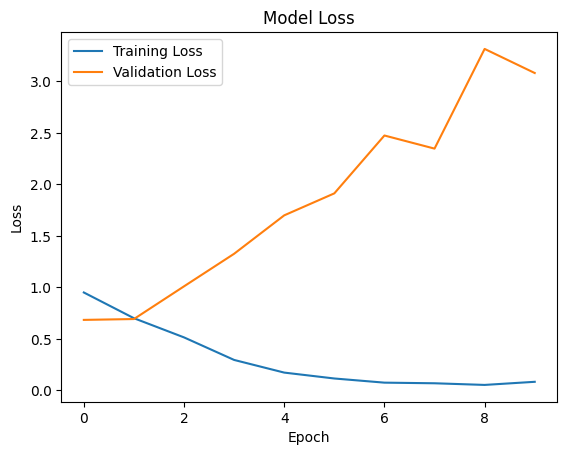

20/20 [==============================] - 1s 75ms/step - loss: 3.0253 - accuracy: 0.5577
Test Accuracy: 55.77%


=============  NEW FINBERT LSTM  =============== 
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 32)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 32, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 lstm_4 (LSTM)               (None, 32, 128)              131584    ['embedding_2[0][0]']         
                                                                                                  
 score_input (InputLayer)    

2023-08-16 19:53:48.837160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:53:49.665544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:53:50.635681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:53:54.073029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:53:55.810107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 1.7305 - accuracy: 0.5193

2023-08-16 19:54:12.340608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:54:12.743072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:54:13.347566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 29s 282ms/step - loss: 1.7305 - accuracy: 0.5193 - val_loss: 0.7475 - val_accuracy: 0.5854
Epoch 2/10
67/67 [==============================] - 6s 92ms/step - loss: 0.7193 - accuracy: 0.5301 - val_loss: 0.6848 - val_accuracy: 0.5854
Epoch 3/10
67/67 [==============================] - 6s 85ms/step - loss: 0.7110 - accuracy: 0.6128 - val_loss: 0.8347 - val_accuracy: 0.5066
Epoch 4/10
67/67 [==============================] - 4s 67ms/step - loss: 0.3583 - accuracy: 0.8468 - val_loss: 1.2569 - val_accuracy: 0.4803
Epoch 5/10
67/67 [==============================] - 4s 56ms/step - loss: 0.2122 - accuracy: 0.9121 - val_loss: 2.0791 - val_accuracy: 0.4690
Epoch 6/10
67/67 [==============================] - 4s 58ms/step - loss: 0.1854 - accuracy: 0.9384 - val_loss: 1.9618 - val_accuracy: 0.4972
Epoch 7/10
67/67 [==============================] - 3s 47ms/step - loss: 0.1163 - accuracy: 0.9638 - val_loss: 2.2220 - val_accuracy: 0.5141
Epoch 8/10
67/67 [====

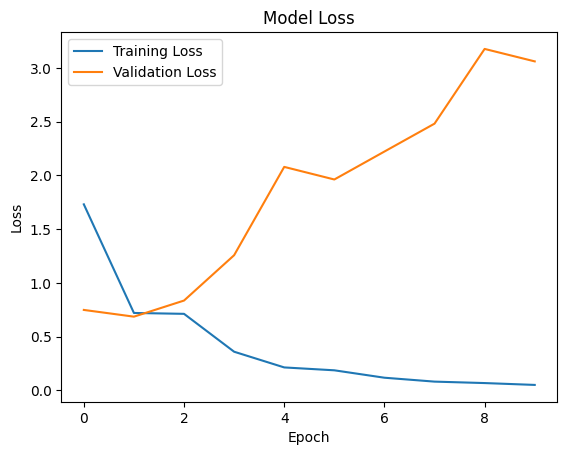

21/21 [==============================] - 2s 88ms/step - loss: 2.7771 - accuracy: 0.5045
Test Accuracy: 50.45%


In [275]:
print("=============  HOT FINBERT LSTM  =============== \n")
model_LSTM(hot_finbert_ret)
print("\n\n=============  NEW FINBERT LSTM  =============== ")
model_LSTM(new_finbert_ret)

=============  HOT CHAT-GPT 3.5 LSTM  =============== 

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 32)]                 0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 32, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 lstm_6 (LSTM)               (None, 32, 128)              131584    ['embedding_3[0][0]']         
                                                                                                  
 score_input (InputLayer)    [(None, 1)]                  0         []                            
                                    

2023-08-16 19:57:11.195818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:57:12.138744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:57:13.303810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:57:16.789770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:57:18.481055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 1.6286 - accuracy: 0.5364

2023-08-16 19:57:36.891121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:57:37.330168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:57:38.046511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 31s 327ms/step - loss: 1.6286 - accuracy: 0.5364 - val_loss: 0.7163 - val_accuracy: 0.6000
Epoch 2/10
64/64 [==============================] - 7s 99ms/step - loss: 0.7234 - accuracy: 0.5438 - val_loss: 0.7368 - val_accuracy: 0.5980
Epoch 3/10
64/64 [==============================] - 4s 56ms/step - loss: 0.6821 - accuracy: 0.6454 - val_loss: 1.0956 - val_accuracy: 0.4119
Epoch 4/10
64/64 [==============================] - 4s 64ms/step - loss: 0.3732 - accuracy: 0.8361 - val_loss: 1.1248 - val_accuracy: 0.4812
Epoch 5/10
64/64 [==============================] - 3s 44ms/step - loss: 0.2791 - accuracy: 0.8940 - val_loss: 1.2805 - val_accuracy: 0.5446
Epoch 6/10
64/64 [==============================] - 4s 59ms/step - loss: 0.1424 - accuracy: 0.9529 - val_loss: 1.4858 - val_accuracy: 0.5564
Epoch 7/10
64/64 [==============================] - 3s 49ms/step - loss: 0.1179 - accuracy: 0.9594 - val_loss: 1.9418 - val_accuracy: 0.5010
Epoch 8/10
64/64 [====

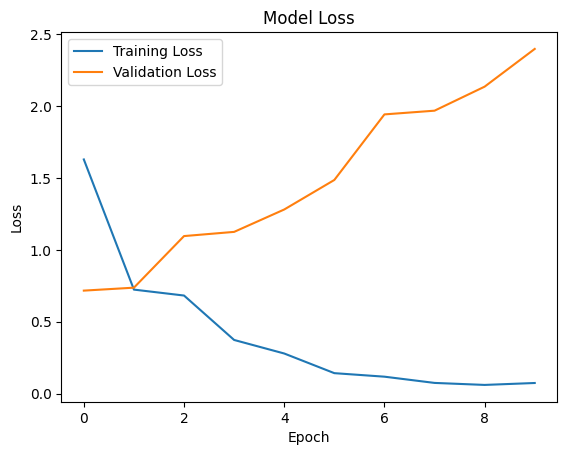

20/20 [==============================] - 2s 122ms/step - loss: 2.7239 - accuracy: 0.5119
Test Accuracy: 51.19%


=============  NEW CHAT-GPT 3.5 LSTM  =============== 
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 34)]                 0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 34, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 lstm_8 (LSTM)               (None, 34, 128)              131584    ['embedding_4[0][0]']         
                                                                                                  
 score_input (InputLaye

2023-08-16 19:58:22.648860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:58:23.854030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:58:25.372938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:58:28.755992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:58:30.865781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 4.6989 - accuracy: 0.5073

2023-08-16 19:58:54.218999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:58:54.700928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 19:58:55.460491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 38s 396ms/step - loss: 4.6989 - accuracy: 0.5073 - val_loss: 0.7486 - val_accuracy: 0.5217
Epoch 2/10
67/67 [==============================] - 7s 100ms/step - loss: 0.7467 - accuracy: 0.5059 - val_loss: 0.7268 - val_accuracy: 0.4237
Epoch 3/10
67/67 [==============================] - 5s 72ms/step - loss: 0.7307 - accuracy: 0.5342 - val_loss: 0.7670 - val_accuracy: 0.4124
Epoch 4/10
67/67 [==============================] - 5s 71ms/step - loss: 0.7428 - accuracy: 0.5351 - val_loss: 0.7236 - val_accuracy: 0.4124
Epoch 5/10
67/67 [==============================] - 4s 53ms/step - loss: 0.5792 - accuracy: 0.7138 - val_loss: 0.8608 - val_accuracy: 0.5574
Epoch 6/10
67/67 [==============================] - 4s 64ms/step - loss: 0.4392 - accuracy: 0.7987 - val_loss: 1.2653 - val_accuracy: 0.4350
Epoch 7/10
67/67 [==============================] - 4s 56ms/step - loss: 0.3524 - accuracy: 0.8562 - val_loss: 1.1026 - val_accuracy: 0.4972
Epoch 8/10
67/67 [===

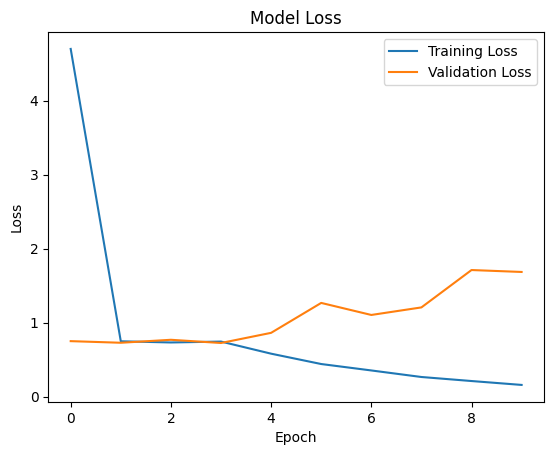

21/21 [==============================] - 1s 72ms/step - loss: 1.7285 - accuracy: 0.4917
Test Accuracy: 49.17%


In [276]:
print("=============  HOT CHAT-GPT 3.5 LSTM  =============== \n")
model_LSTM(hot_chatgpt_ret)
print("\n\n=============  NEW CHAT-GPT 3.5 LSTM  =============== ")
model_LSTM(new_chatgpt_ret)

In [277]:
def model_LSTM_vader(df, max_words=10000):
    df['text'] = df['text'].astype(str)

    # Label encoding for 'ticker' column
    ticker_encoder = LabelEncoder()
    df['ticker'] = ticker_encoder.fit_transform(df['ticker'])

    # Separate features and target variable
    X = df[['text', 'ticker', 'neg', 'neu', 'pos', 'compound']]
    y = (df['ret'] > 0).astype(int)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Tokenize and pad the 'text' column for training and testing sets
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train['text'])
    train_text_sequences = tokenizer.texts_to_sequences(X_train['text'])
    test_text_sequences = tokenizer.texts_to_sequences(X_test['text'])
    max_sequence_length = max(len(s) for s in train_text_sequences + test_text_sequences)
    train_text_padded = pad_sequences(train_text_sequences, maxlen=max_sequence_length)
    test_text_padded = pad_sequences(test_text_sequences, maxlen=max_sequence_length)

    # Text Input (LSTM)
    text_input = Input(shape=(max_sequence_length,), name='text_input')
    text_embedding = Embedding(input_dim=max_words, output_dim=128)(text_input)
    text_lstm = LSTM(128, return_sequences=True)(text_embedding)
    text_lstm2 = LSTM(64)(text_lstm)
    text_dense = Dense(32, activation='relu')(text_lstm2)

    # Ticker Input (numeric)
    ticker_input = Input(shape=(1,), name='ticker_input')
    ticker_dense = Dense(16, activation='relu')(ticker_input)

    # Other Numeric Inputs (neg, neu, pos, compound)
    other_inputs = Input(shape=(4,), name='other_inputs')  # 4 numeric features
    other_dense = Dense(16, activation='relu')(other_inputs)

    # Concatenate all inputs
    concatenated = concatenate([text_dense, ticker_dense, other_dense])
    dense_1 = Dense(64, activation='relu')(concatenated)
    output = Dense(1, activation='sigmoid')(dense_1)

    # Build and compile the model
    model = Model(inputs=[text_input, ticker_input, other_inputs], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Model summary
    model.summary()

    # Train the model
    history = model.fit(
        {'text_input': train_text_padded, 'ticker_input': X_train['ticker'].values, 'other_inputs': X_train[['neg', 'neu', 'pos', 'compound']].values},
        y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.2
    )

    # Plot the loss
    plot_loss(history)

    # Evaluate the model
    loss, accuracy = model.evaluate(
        {'text_input': test_text_padded, 'ticker_input': X_test['ticker'].values, 'other_inputs': X_test[['neg', 'neu', 'pos', 'compound']].values},
        y_test
    )
    print("Test Accuracy: {:.2f}%".format(accuracy * 100))

    return model


=============  HOT CHAT-GPT 3.5 LSTM  =============== 

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 32)]                 0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 32, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 lstm_10 (LSTM)              (None, 32, 128)              131584    ['embedding_5[0][0]']         
                                                                                                  
 lstm_11 (LSTM)              (None, 64)                   49408     ['lstm_10[0][0]']             
                                    

2023-08-16 20:00:25.340202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:00:26.072050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:00:27.246607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:00:30.594385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:00:32.014185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 2.1905 - accuracy: 0.5277

2023-08-16 20:00:51.372478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:00:51.914194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:00:52.580920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 32s 354ms/step - loss: 2.1905 - accuracy: 0.5277 - val_loss: 1.1081 - val_accuracy: 0.6067
Epoch 2/10
64/64 [==============================] - 9s 135ms/step - loss: 0.7781 - accuracy: 0.5573 - val_loss: 0.6726 - val_accuracy: 0.6107
Epoch 3/10
64/64 [==============================] - 5s 76ms/step - loss: 0.6737 - accuracy: 0.6542 - val_loss: 0.9321 - val_accuracy: 0.5632
Epoch 4/10
64/64 [==============================] - 5s 79ms/step - loss: 0.3149 - accuracy: 0.8631 - val_loss: 1.2509 - val_accuracy: 0.5158
Epoch 5/10
64/64 [==============================] - 4s 67ms/step - loss: 0.2325 - accuracy: 0.9170 - val_loss: 1.8279 - val_accuracy: 0.5237
Epoch 6/10
64/64 [==============================] - 5s 70ms/step - loss: 0.1421 - accuracy: 0.9417 - val_loss: 2.0679 - val_accuracy: 0.4980
Epoch 7/10
64/64 [==============================] - 3s 52ms/step - loss: 0.0867 - accuracy: 0.9679 - val_loss: 2.1955 - val_accuracy: 0.5020
Epoch 8/10
64/64 [===

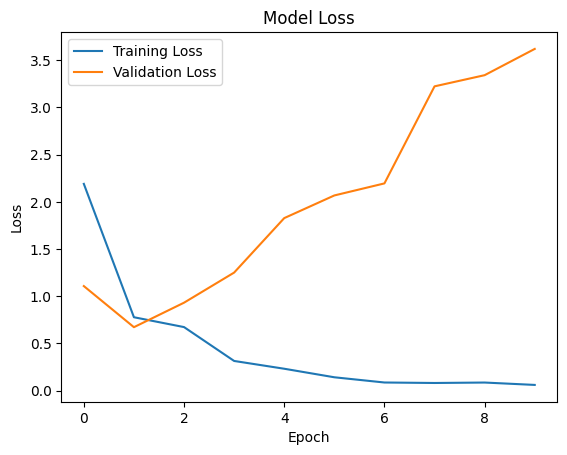

20/20 [==============================] - 2s 92ms/step - loss: 3.5101 - accuracy: 0.4818
Test Accuracy: 48.18%


=============  NEW CHAT-GPT 3.5 LSTM  =============== 
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 32)]                 0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 32, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 lstm_12 (LSTM)              (None, 32, 128)              131584    ['embedding_6[0][0]']         
                                                                                                  
 lstm_13 (LSTM)         

2023-08-16 20:01:42.273756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:01:43.026065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:01:44.038750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:01:47.241111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:01:48.960711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 5.3257 - accuracy: 0.5023

2023-08-16 20:02:06.976747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:02:07.417378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:02:08.123349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 31s 314ms/step - loss: 5.3257 - accuracy: 0.5023 - val_loss: 0.7396 - val_accuracy: 0.5385
Epoch 2/10
67/67 [==============================] - 7s 108ms/step - loss: 0.7477 - accuracy: 0.5042 - val_loss: 0.7237 - val_accuracy: 0.4146
Epoch 3/10
67/67 [==============================] - 6s 91ms/step - loss: 0.7510 - accuracy: 0.5122 - val_loss: 0.6813 - val_accuracy: 0.5854
Epoch 4/10
67/67 [==============================] - 5s 75ms/step - loss: 0.7857 - accuracy: 0.5263 - val_loss: 0.7191 - val_accuracy: 0.5816
Epoch 5/10
67/67 [==============================] - 5s 68ms/step - loss: 0.6776 - accuracy: 0.6414 - val_loss: 0.9942 - val_accuracy: 0.4296
Epoch 6/10
67/67 [==============================] - 5s 71ms/step - loss: 0.4396 - accuracy: 0.8036 - val_loss: 1.1754 - val_accuracy: 0.5629
Epoch 7/10
67/67 [==============================] - 5s 79ms/step - loss: 0.4087 - accuracy: 0.8261 - val_loss: 1.2242 - val_accuracy: 0.4803
Epoch 8/10
67/67 [===

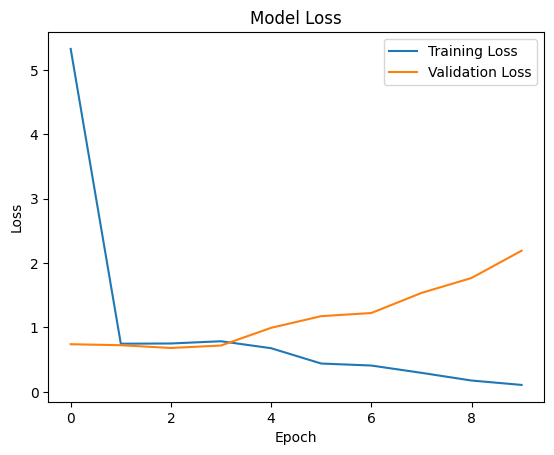

21/21 [==============================] - 2s 110ms/step - loss: 2.0295 - accuracy: 0.5495
Test Accuracy: 54.95%


In [278]:
print("=============  HOT CHAT-GPT 3.5 LSTM  =============== \n")
model_LSTM_vader(hot_vader_ret)
print("\n\n=============  NEW CHAT-GPT 3.5 LSTM  =============== ")
model_LSTM_vader(new_vader_ret)

# CNN

In [279]:
def model_CNN(df, max_words=10000):
    df['text'] = df['text'].astype(str)

    # One-hot encoding for 'label' and 'ticker' columns
    one_hot_encoder = OneHotEncoder(sparse=False)
    label_one_hot = one_hot_encoder.fit_transform(df[['label']])
    ticker_one_hot = one_hot_encoder.fit_transform(df[['ticker']])

    df['score'] = df['score'].astype(float)

    # Separate features and target variable
    X_text = df['text']
    X_ticker = ticker_one_hot
    X_label = label_one_hot
    X_score = df['score'].values.reshape(-1, 1)
    y = (df['ret'] > 0).astype(int)

    # Split the data into training and testing sets
    X_train_text, X_test_text, X_train_ticker, X_test_ticker, X_train_label, X_test_label, X_train_score, X_test_score, y_train, y_test = train_test_split(X_text, X_ticker, X_label, X_score, y, test_size=0.2, random_state=42)

    # Tokenize and pad the 'text' column for training and testing sets
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train_text)
    train_text_sequences = tokenizer.texts_to_sequences(X_train_text)
    test_text_sequences = tokenizer.texts_to_sequences(X_test_text)
    max_sequence_length = max(len(s) for s in train_text_sequences + test_text_sequences)
    train_text_padded = pad_sequences(train_text_sequences, maxlen=max_sequence_length)
    test_text_padded = pad_sequences(test_text_sequences, maxlen=max_sequence_length)

    # Text Input (CNN)
    text_input = Input(shape=(max_sequence_length,), name='text_input')
    text_embedding = Embedding(input_dim=max_words, output_dim=128)(text_input)
    text_conv1 = Conv1D(128, 3, activation='relu')(text_embedding)  # Reduced kernel size
    text_pool1 = MaxPooling1D(3)(text_conv1)                        # Reduced pooling size
    text_conv2 = Conv1D(128, 3, activation='relu')(text_pool1)      # Reduced kernel size
    text_pool2 = MaxPooling1D(3)(text_conv2)                        # Reduced pooling size
    text_flat = GlobalMaxPooling1D()(text_pool2)
    text_dense = Dense(32, activation='relu')(text_flat)
    # Ticker Input (numeric)
    ticker_input_shape = X_ticker.shape[1]
    ticker_input = Input(shape=(ticker_input_shape,), name='ticker_input')

    # Label Input (numeric)
    label_input_shape = X_label.shape[1]
    label_input = Input(shape=(label_input_shape,), name='label_input')

    # Score Input (numeric)
    score_input = Input(shape=(1,), name='score_input')

    # Concatenate all inputs
    concatenated = concatenate([text_dense, ticker_input, label_input, score_input])
    dense_1 = Dense(64, activation='relu')(concatenated)
    output = Dense(1, activation='sigmoid')(dense_1)

    # Build and compile the model
    model = Model(inputs=[text_input, ticker_input, label_input, score_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Model summary
    model.summary()

    # Train the model
    history = model.fit(
        {'text_input': train_text_padded, 'ticker_input': X_train_ticker, 'label_input': X_train_label, 'score_input': X_train_score},
        y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.2
    )

    # Plot the loss
    plot_loss(history)

    # Evaluate the model
    loss, accuracy = model.evaluate(
        {'text_input': test_text_padded, 'ticker_input': X_test_ticker, 'label_input': X_test_label, 'score_input': X_test_score},
        y_test
    )
    print("Test Accuracy: {:.2f}%".format(accuracy * 100))

=============  HOT FINBERT CNN  =============== 



/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 32)]                 0         []                            
                                                                                                  
 embedding_7 (Embedding)     (None, 32, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 conv1d (Conv1D)             (None, 30, 128)              49280     ['embedding_7[0][0]']         
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 10, 128)              0         ['conv1d[0][0]']              
 D)                                                                                         

2023-08-16 20:03:56.401863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 0.6767 - accuracy: 0.5889

2023-08-16 20:04:21.681841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 42s 348ms/step - loss: 0.6767 - accuracy: 0.5889 - val_loss: 0.6662 - val_accuracy: 0.6126
Epoch 2/10
64/64 [==============================] - 7s 111ms/step - loss: 0.6659 - accuracy: 0.6057 - val_loss: 0.6669 - val_accuracy: 0.6126
Epoch 3/10
64/64 [==============================] - 6s 89ms/step - loss: 0.5904 - accuracy: 0.6601 - val_loss: 0.8161 - val_accuracy: 0.4822
Epoch 4/10
64/64 [==============================] - 3s 54ms/step - loss: 0.4342 - accuracy: 0.7801 - val_loss: 1.0502 - val_accuracy: 0.5217
Epoch 5/10
64/64 [==============================] - 3s 53ms/step - loss: 0.3639 - accuracy: 0.8068 - val_loss: 1.1925 - val_accuracy: 0.5534
Epoch 6/10
64/64 [==============================] - 4s 54ms/step - loss: 0.3379 - accuracy: 0.8162 - val_loss: 1.2915 - val_accuracy: 0.5613
Epoch 7/10
64/64 [==============================] - 3s 48ms/step - loss: 0.3266 - accuracy: 0.8197 - val_loss: 1.1611 - val_accuracy: 0.5553
Epoch 8/10
64/64 [===

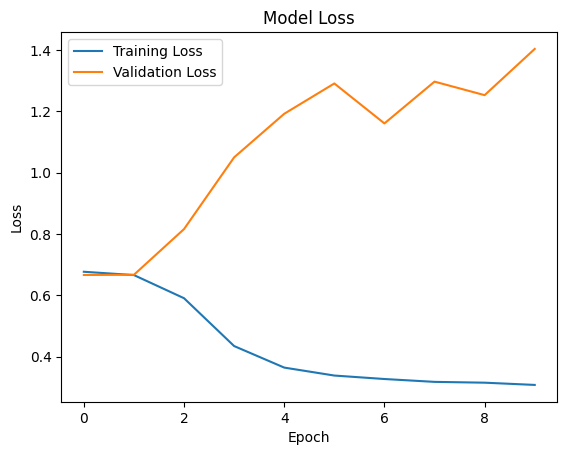

20/20 [==============================] - 2s 92ms/step - loss: 1.2116 - accuracy: 0.5561
Test Accuracy: 55.61%


=============  NEW FINERT CNN  =============== 


/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 32)]                 0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 32, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 conv1d_2 (Conv1D)           (None, 30, 128)              49280     ['embedding_8[0][0]']         
                                                                                                  
 max_pooling1d_2 (MaxPoolin  (None, 10, 128)              0         ['conv1d_2[0][0]']            
 g1D)                                                                                       

2023-08-16 20:05:02.379484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5352

2023-08-16 20:05:22.891260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 25s 306ms/step - loss: 0.6931 - accuracy: 0.5352 - val_loss: 0.6837 - val_accuracy: 0.5854
Epoch 2/10
67/67 [==============================] - 8s 123ms/step - loss: 0.6884 - accuracy: 0.5493 - val_loss: 0.6800 - val_accuracy: 0.5854
Epoch 3/10
67/67 [==============================] - 7s 100ms/step - loss: 0.6537 - accuracy: 0.5794 - val_loss: 0.7220 - val_accuracy: 0.5666
Epoch 4/10
67/67 [==============================] - 9s 136ms/step - loss: 0.4638 - accuracy: 0.7317 - val_loss: 0.9341 - val_accuracy: 0.5084
Epoch 5/10
67/67 [==============================] - 6s 81ms/step - loss: 0.3666 - accuracy: 0.7650 - val_loss: 1.1258 - val_accuracy: 0.5460
Epoch 6/10
67/67 [==============================] - 3s 43ms/step - loss: 0.3335 - accuracy: 0.7928 - val_loss: 1.2156 - val_accuracy: 0.5591
Epoch 7/10
67/67 [==============================] - 4s 53ms/step - loss: 0.3192 - accuracy: 0.8022 - val_loss: 1.2239 - val_accuracy: 0.5535
Epoch 8/10
67/67 [=

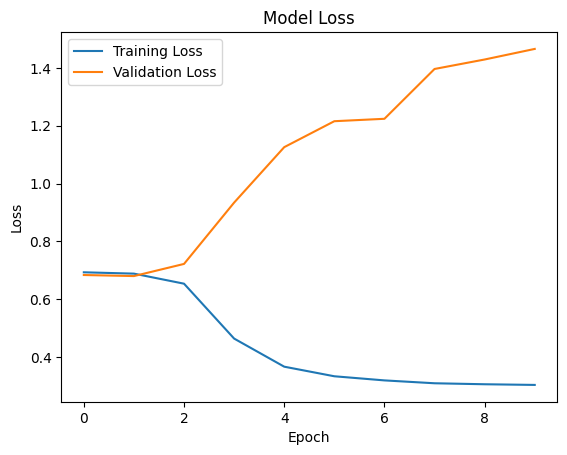

21/21 [==============================] - 2s 85ms/step - loss: 1.4277 - accuracy: 0.5480
Test Accuracy: 54.80%


In [280]:
print("=============  HOT FINBERT CNN  =============== \n")
model_CNN(hot_finbert_ret)
print("\n\n=============  NEW FINERT CNN  =============== ")
model_CNN(new_finbert_ret)

=============  HOT CHAT GPT 3.5 CNN  =============== 



/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 32)]                 0         []                            
                                                                                                  
 embedding_9 (Embedding)     (None, 32, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 conv1d_4 (Conv1D)           (None, 30, 128)              49280     ['embedding_9[0][0]']         
                                                                                                  
 max_pooling1d_4 (MaxPoolin  (None, 10, 128)              0         ['conv1d_4[0][0]']            
 g1D)                                                                                       

2023-08-16 20:06:22.648099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 0.6758 - accuracy: 0.5993

2023-08-16 20:06:45.111254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 27s 325ms/step - loss: 0.6758 - accuracy: 0.5993 - val_loss: 0.6714 - val_accuracy: 0.6000
Epoch 2/10
64/64 [==============================] - 8s 122ms/step - loss: 0.6690 - accuracy: 0.6028 - val_loss: 0.6714 - val_accuracy: 0.5980
Epoch 3/10
64/64 [==============================] - 24s 381ms/step - loss: 0.5975 - accuracy: 0.6721 - val_loss: 0.7735 - val_accuracy: 0.5802
Epoch 4/10
64/64 [==============================] - 13s 203ms/step - loss: 0.4147 - accuracy: 0.7865 - val_loss: 0.9960 - val_accuracy: 0.5861
Epoch 5/10
64/64 [==============================] - 6s 91ms/step - loss: 0.3405 - accuracy: 0.8182 - val_loss: 0.9929 - val_accuracy: 0.5782
Epoch 6/10
64/64 [==============================] - 5s 71ms/step - loss: 0.3178 - accuracy: 0.8212 - val_loss: 1.0829 - val_accuracy: 0.5762
Epoch 7/10
64/64 [==============================] - 3s 52ms/step - loss: 0.3157 - accuracy: 0.8192 - val_loss: 1.0895 - val_accuracy: 0.5762
Epoch 8/10
64/64 

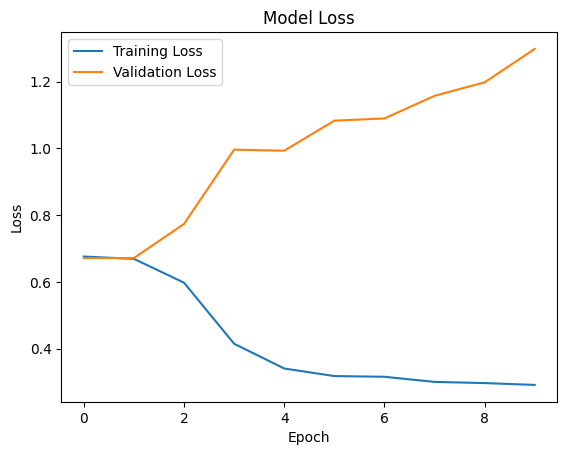

20/20 [==============================] - 2s 106ms/step - loss: 1.3122 - accuracy: 0.5689
Test Accuracy: 56.89%


=============  NEW CHAT GPT 3.5 CNN  =============== 


/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 34)]                 0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, 34, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 conv1d_6 (Conv1D)           (None, 32, 128)              49280     ['embedding_10[0][0]']        
                                                                                                  
 max_pooling1d_6 (MaxPoolin  (None, 10, 128)              0         ['conv1d_6[0][0]']            
 g1D)                                                                                      

2023-08-16 20:07:59.857906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.5441

2023-08-16 20:08:25.460881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 30s 351ms/step - loss: 0.6902 - accuracy: 0.5441 - val_loss: 0.6785 - val_accuracy: 0.5951
Epoch 2/10
67/67 [==============================] - 5s 72ms/step - loss: 0.6838 - accuracy: 0.5582 - val_loss: 0.6836 - val_accuracy: 0.5838
Epoch 3/10
67/67 [==============================] - 5s 78ms/step - loss: 0.6364 - accuracy: 0.5898 - val_loss: 0.7252 - val_accuracy: 0.5574
Epoch 4/10
67/67 [==============================] - 5s 75ms/step - loss: 0.5080 - accuracy: 0.6902 - val_loss: 0.8565 - val_accuracy: 0.5556
Epoch 5/10
67/67 [==============================] - 3s 51ms/step - loss: 0.4467 - accuracy: 0.7313 - val_loss: 0.9718 - val_accuracy: 0.5669
Epoch 6/10
67/67 [==============================] - 3s 38ms/step - loss: 0.4174 - accuracy: 0.7515 - val_loss: 1.1002 - val_accuracy: 0.5706
Epoch 7/10
67/67 [==============================] - 3s 40ms/step - loss: 0.4055 - accuracy: 0.7577 - val_loss: 1.1095 - val_accuracy: 0.5499
Epoch 8/10
67/67 [====

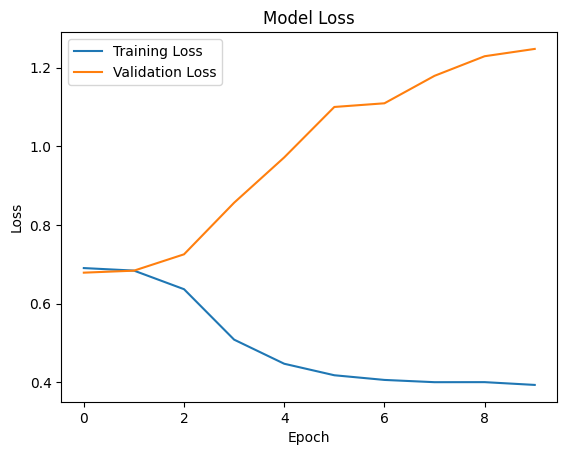

21/21 [==============================] - 2s 77ms/step - loss: 1.0978 - accuracy: 0.5279
Test Accuracy: 52.79%


In [281]:
print("=============  HOT CHAT GPT 3.5 CNN  =============== \n")
model_CNN(hot_chatgpt_ret)
print("\n\n=============  NEW CHAT GPT 3.5 CNN  =============== ")
model_CNN(new_chatgpt_ret)

In [282]:
def model_CNN_vader(df, max_words=10000):
    df['text'] = df['text'].astype(str)

    # One-hot encoding for 'ticker' column
    one_hot_encoder = OneHotEncoder(sparse=False)
    ticker_one_hot = one_hot_encoder.fit_transform(df[['ticker']])

    # Separate features and target variable
    X_text = df['text']
    X_ticker = ticker_one_hot
    X_neg = df['neg'].values.reshape(-1, 1)
    X_neu = df['neu'].values.reshape(-1, 1)
    X_pos = df['pos'].values.reshape(-1, 1)
    X_compound = df['compound'].values.reshape(-1, 1)
    y = (df['ret'] > 0).astype(int)

    # Split the data into training and testing sets
    splits = train_test_split(X_text, X_ticker, X_neg, X_neu, X_pos, X_compound, y, test_size=0.2, random_state=42)
    X_train_text, X_test_text, X_train_ticker, X_test_ticker, X_train_neg, X_test_neg, X_train_neu, X_test_neu, X_train_pos, X_test_pos, X_train_compound, X_test_compound, y_train, y_test = splits

    # Tokenize and pad the 'text' column
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train_text)
    train_text_sequences = tokenizer.texts_to_sequences(X_train_text)
    test_text_sequences = tokenizer.texts_to_sequences(X_test_text)
    max_sequence_length = max(len(s) for s in train_text_sequences + test_text_sequences)
    train_text_padded = pad_sequences(train_text_sequences, maxlen=max_sequence_length)
    test_text_padded = pad_sequences(test_text_sequences, maxlen=max_sequence_length)

    # Text Input (CNN)
    text_input = Input(shape=(max_sequence_length,), name='text_input')
    text_embedding = Embedding(input_dim=max_words, output_dim=128)(text_input)
    text_conv1 = Conv1D(128, 3, activation='relu')(text_embedding)
    text_pool1 = MaxPooling1D(3)(text_conv1)
    text_conv2 = Conv1D(128, 3, activation='relu')(text_pool1)
    text_pool2 = MaxPooling1D(3)(text_conv2)
    text_flat = GlobalMaxPooling1D()(text_pool2)
    text_dense = Dense(32, activation='relu')(text_flat)

    # Additional Inputs (numeric)
    ticker_input = Input(shape=(X_ticker.shape[1],), name='ticker_input')
    neg_input = Input(shape=(1,), name='neg_input')
    neu_input = Input(shape=(1,), name='neu_input')
    pos_input = Input(shape=(1,), name='pos_input')
    compound_input = Input(shape=(1,), name='compound_input')

    # Concatenate all inputs
    concatenated = concatenate([text_dense, ticker_input, neg_input, neu_input, pos_input, compound_input])
    dense_1 = Dense(64, activation='relu')(concatenated)
    output = Dense(1, activation='sigmoid')(dense_1)

    # Build and compile the model
    model = Model(inputs=[text_input, ticker_input, neg_input, neu_input, pos_input, compound_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        {'text_input': train_text_padded, 'ticker_input': X_train_ticker, 'neg_input': X_train_neg, 'neu_input': X_train_neu, 'pos_input': X_train_pos, 'compound_input': X_train_compound},
        y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.2
    )

    # Plot the loss
    plot_loss(history)

    # Evaluate the model
    loss, accuracy = model.evaluate(
        {'text_input': test_text_padded, 'ticker_input': X_test_ticker, 'neg_input': X_test_neg, 'neu_input': X_test_neu, 'pos_input': X_test_pos, 'compound_input': X_test_compound},
        y_test
    )
    print("Test Accuracy: {:.2f}%".format(accuracy * 100))

=============  HOT VADER CNN  =============== 



/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10


2023-08-16 20:09:18.747779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 0.6738 - accuracy: 0.6057

2023-08-16 20:09:38.873949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 25s 299ms/step - loss: 0.6738 - accuracy: 0.6057 - val_loss: 0.6667 - val_accuracy: 0.6087
Epoch 2/10
64/64 [==============================] - 8s 117ms/step - loss: 0.6649 - accuracy: 0.6122 - val_loss: 0.6662 - val_accuracy: 0.6067
Epoch 3/10
64/64 [==============================] - 5s 82ms/step - loss: 0.5730 - accuracy: 0.6986 - val_loss: 0.7519 - val_accuracy: 0.5336
Epoch 4/10
64/64 [==============================] - 4s 67ms/step - loss: 0.4080 - accuracy: 0.7821 - val_loss: 0.9865 - val_accuracy: 0.5632
Epoch 5/10
64/64 [==============================] - 4s 57ms/step - loss: 0.3568 - accuracy: 0.8137 - val_loss: 1.0809 - val_accuracy: 0.5336
Epoch 6/10
64/64 [==============================] - 4s 57ms/step - loss: 0.3323 - accuracy: 0.8207 - val_loss: 1.2567 - val_accuracy: 0.5474
Epoch 7/10
64/64 [==============================] - 3s 42ms/step - loss: 0.3282 - accuracy: 0.8295 - val_loss: 1.1975 - val_accuracy: 0.5494
Epoch 8/10
64/64 [===

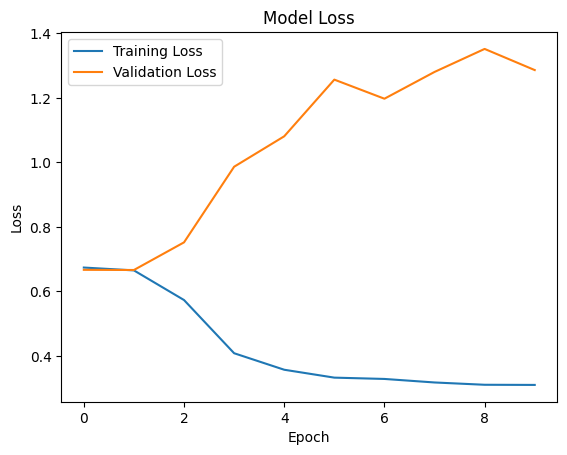

20/20 [==============================] - 2s 88ms/step - loss: 1.1810 - accuracy: 0.5513
Test Accuracy: 55.13%


=============  NEW VADER CNN  =============== 


/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10


2023-08-16 20:10:20.268896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.5475

2023-08-16 20:10:42.193938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 27s 318ms/step - loss: 0.6903 - accuracy: 0.5475 - val_loss: 0.6844 - val_accuracy: 0.5835
Epoch 2/10
67/67 [==============================] - 10s 142ms/step - loss: 0.6757 - accuracy: 0.5630 - val_loss: 0.6898 - val_accuracy: 0.5741
Epoch 3/10
67/67 [==============================] - 6s 97ms/step - loss: 0.5224 - accuracy: 0.7077 - val_loss: 0.8607 - val_accuracy: 0.5629
Epoch 4/10
67/67 [==============================] - 6s 81ms/step - loss: 0.3828 - accuracy: 0.7810 - val_loss: 1.0222 - val_accuracy: 0.5328
Epoch 5/10
67/67 [==============================] - 4s 55ms/step - loss: 0.3407 - accuracy: 0.7928 - val_loss: 1.1066 - val_accuracy: 0.5441
Epoch 6/10
67/67 [==============================] - 4s 64ms/step - loss: 0.3251 - accuracy: 0.7975 - val_loss: 1.1662 - val_accuracy: 0.5535
Epoch 7/10
67/67 [==============================] - 5s 70ms/step - loss: 0.3127 - accuracy: 0.8059 - val_loss: 1.2738 - val_accuracy: 0.5647
Epoch 8/10
67/67 [==

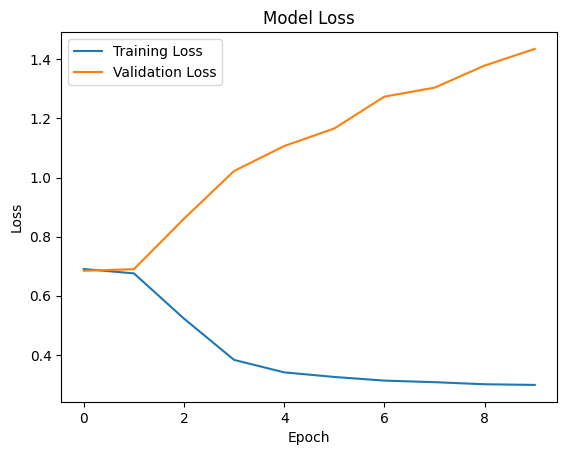

21/21 [==============================] - 2s 89ms/step - loss: 1.2673 - accuracy: 0.5541
Test Accuracy: 55.41%


In [283]:
print("=============  HOT VADER CNN  =============== \n")
model_CNN_vader(hot_vader_ret)
print("\n\n=============  NEW VADER CNN  =============== ")
model_CNN_vader(new_vader_ret)

# CNN-LSTM

In [284]:
def model_CNN_LSTM(df, max_words=10000):
    df['text'] = df['text'].astype(str)

    # One-hot encoding for 'label' and 'ticker' columns
    one_hot_encoder = OneHotEncoder(sparse=False)
    label_one_hot = one_hot_encoder.fit_transform(df[['label']])
    ticker_one_hot = one_hot_encoder.fit_transform(df[['ticker']])
    df['score'] = df['score'].astype(float)

    # Separate features and target variable
    X_text = df['text']
    X_ticker = ticker_one_hot
    X_label = label_one_hot
    X_score = df['score'].values.reshape(-1, 1)
    y = (df['ret'] > 0).astype(int)

    # Split the data into training and testing sets
    X_train_text, X_test_text, X_train_ticker, X_test_ticker, X_train_label, X_test_label, X_train_score, X_test_score, y_train, y_test = train_test_split(X_text, X_ticker, X_label, X_score, y, test_size=0.2, random_state=42)

    # Tokenize and pad the 'text' column for training and testing sets
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train_text)
    train_text_sequences = tokenizer.texts_to_sequences(X_train_text)
    test_text_sequences = tokenizer.texts_to_sequences(X_test_text)
    max_sequence_length = max(len(s) for s in train_text_sequences + test_text_sequences)
    train_text_padded = pad_sequences(train_text_sequences, maxlen=max_sequence_length)
    test_text_padded = pad_sequences(test_text_sequences, maxlen=max_sequence_length)

    # Text Input (CNN followed by LSTM)
    text_input = Input(shape=(max_sequence_length,), name='text_input')
    text_embedding = Embedding(input_dim=max_words, output_dim=128)(text_input)
    text_conv1 = Conv1D(128, 3, activation='relu')(text_embedding)
    text_pool1 = MaxPooling1D(3)(text_conv1)
    text_conv2 = Conv1D(128, 3, activation='relu')(text_pool1)
    text_pool2 = MaxPooling1D(3)(text_conv2)
    text_lstm1 = LSTM(128, return_sequences=True)(text_pool2)
    text_lstm2 = LSTM(64)(text_lstm1)  # Additional LSTM layer
    text_dense = Dense(32, activation='relu')(text_lstm2)

    # Ticker Input (numeric)
    ticker_input_shape = X_ticker.shape[1]
    ticker_input = Input(shape=(ticker_input_shape,), name='ticker_input')
    ticker_dense = Dense(16, activation='relu')(ticker_input)

    # Label Input (numeric)
    label_input_shape = X_label.shape[1]
    label_input = Input(shape=(label_input_shape,), name='label_input')
    label_dense = Dense(16, activation='relu')(label_input)

    # Score Input (numeric)
    score_input = Input(shape=(1,), name='score_input')
    score_dense1 = Dense(16, activation='relu')(score_input)
    score_dense2 = Dense(8, activation='relu')(score_dense1)  # Additional dense layer

    # Concatenate all inputs
    concatenated = concatenate([text_dense, ticker_dense, label_dense, score_dense2])
    dense_1 = Dense(64, activation='relu')(concatenated)
    output = Dense(1, activation='sigmoid')(dense_1)

    # Build and compile the model
    model = Model(inputs=[text_input, ticker_input, label_input, score_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Model summary
    model.summary()

    # Train the model
    history = model.fit(
        {'text_input': train_text_padded, 'ticker_input': X_train_ticker, 'label_input': X_train_label, 'score_input': X_train_score},
        y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.2
    )

    # Plot the loss
    plot_loss(history)

    # Evaluate the model
    loss, accuracy = model.evaluate(
        {'text_input': test_text_padded, 'ticker_input': X_test_ticker, 'label_input': X_test_label, 'score_input': X_test_score},
        y_test
    )
    print("Test Accuracy: {:.2f}%".format(accuracy * 100))


=============  HOT FINBERT CNN-LSTM  =============== 



/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 32)]                 0         []                            
                                                                                                  
 embedding_13 (Embedding)    (None, 32, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 conv1d_12 (Conv1D)          (None, 30, 128)              49280     ['embedding_13[0][0]']        
                                                                                                  
 max_pooling1d_12 (MaxPooli  (None, 10, 128)              0         ['conv1d_12[0][0]']           
 ng1D)                                                                                     

2023-08-16 20:21:39.553257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:21:43.138198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:21:45.412385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:21:55.172983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:21:56.862259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 0.6762 - accuracy: 0.5889

2023-08-16 20:22:22.577556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:22:23.424316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:22:24.590598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 55s 492ms/step - loss: 0.6762 - accuracy: 0.5889 - val_loss: 0.6686 - val_accuracy: 0.6126
Epoch 2/10
64/64 [==============================] - 10s 160ms/step - loss: 0.6698 - accuracy: 0.6057 - val_loss: 0.6699 - val_accuracy: 0.6126
Epoch 3/10
64/64 [==============================] - 8s 125ms/step - loss: 0.6647 - accuracy: 0.6131 - val_loss: 0.6842 - val_accuracy: 0.6047
Epoch 4/10
64/64 [==============================] - 7s 105ms/step - loss: 0.5708 - accuracy: 0.6996 - val_loss: 0.8280 - val_accuracy: 0.5692
Epoch 5/10
64/64 [==============================] - 5s 77ms/step - loss: 0.4258 - accuracy: 0.7806 - val_loss: 1.0425 - val_accuracy: 0.5573
Epoch 6/10
64/64 [==============================] - 5s 76ms/step - loss: 0.3734 - accuracy: 0.7999 - val_loss: 1.2130 - val_accuracy: 0.5593
Epoch 7/10
64/64 [==============================] - 5s 74ms/step - loss: 0.3447 - accuracy: 0.8123 - val_loss: 1.4613 - val_accuracy: 0.5395
Epoch 8/10
64/64 [

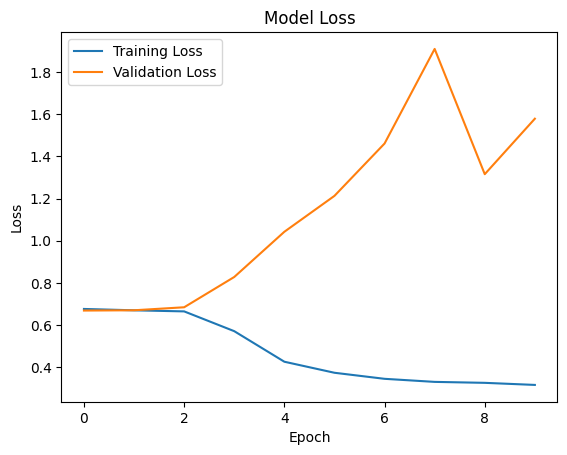

20/20 [==============================] - 2s 124ms/step - loss: 1.3795 - accuracy: 0.5355
Test Accuracy: 53.55%


=============  NEW FINERT CNN-LSTM   =============== 


/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 32)]                 0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, 32, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 conv1d_14 (Conv1D)          (None, 30, 128)              49280     ['embedding_14[0][0]']        
                                                                                                  
 max_pooling1d_14 (MaxPooli  (None, 10, 128)              0         ['conv1d_14[0][0]']           
 ng1D)                                                                                     

2023-08-16 20:24:05.057575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:24:08.280862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:24:09.284506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:24:13.784535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:24:16.413511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 0.6908 - accuracy: 0.5470

2023-08-16 20:24:50.492559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:24:51.770247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:24:52.717303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 88s 548ms/step - loss: 0.6908 - accuracy: 0.5470 - val_loss: 0.6836 - val_accuracy: 0.5779
Epoch 2/10
67/67 [==============================] - 12s 173ms/step - loss: 0.6884 - accuracy: 0.5442 - val_loss: 0.6855 - val_accuracy: 0.5610
Epoch 3/10
67/67 [==============================] - 8s 124ms/step - loss: 0.6876 - accuracy: 0.5489 - val_loss: 0.6811 - val_accuracy: 0.5854
Epoch 4/10
67/67 [==============================] - 9s 139ms/step - loss: 0.6778 - accuracy: 0.5667 - val_loss: 0.7030 - val_accuracy: 0.4859
Epoch 5/10
67/67 [==============================] - 6s 91ms/step - loss: 0.5089 - accuracy: 0.7162 - val_loss: 0.9069 - val_accuracy: 0.5704
Epoch 6/10
67/67 [==============================] - 6s 83ms/step - loss: 0.4012 - accuracy: 0.7655 - val_loss: 1.0108 - val_accuracy: 0.5779
Epoch 7/10
67/67 [==============================] - 8s 107ms/step - loss: 0.3462 - accuracy: 0.7815 - val_loss: 1.3357 - val_accuracy: 0.4991
Epoch 8/10
67/67 

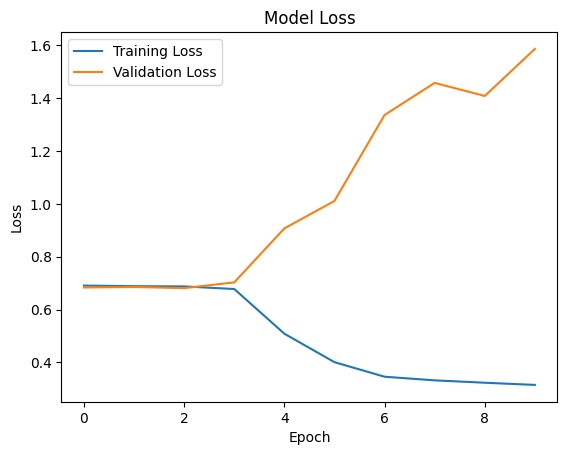

21/21 [==============================] - 3s 173ms/step - loss: 1.5130 - accuracy: 0.5526
Test Accuracy: 55.26%


In [285]:
print("=============  HOT FINBERT CNN-LSTM  =============== \n")
model_CNN_LSTM(hot_finbert_ret)
print("\n\n=============  NEW FINERT CNN-LSTM   =============== ")
model_CNN_LSTM(new_finbert_ret)

=============  HOT CHAT GPT 3.5 CNN-LSTM  =============== 



/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 32)]                 0         []                            
                                                                                                  
 embedding_15 (Embedding)    (None, 32, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 conv1d_16 (Conv1D)          (None, 30, 128)              49280     ['embedding_15[0][0]']        
                                                                                                  
 max_pooling1d_16 (MaxPooli  (None, 10, 128)              0         ['conv1d_16[0][0]']           
 ng1D)                                                                                     

2023-08-16 20:26:31.090657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:26:34.491290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:26:36.273542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:26:42.398178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:26:44.596148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 0.6763 - accuracy: 0.5983

2023-08-16 20:27:20.301371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:27:21.272704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:27:22.029337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 61s 654ms/step - loss: 0.6763 - accuracy: 0.5983 - val_loss: 0.6731 - val_accuracy: 0.5980
Epoch 2/10
64/64 [==============================] - 12s 181ms/step - loss: 0.6736 - accuracy: 0.6028 - val_loss: 0.6752 - val_accuracy: 0.5980
Epoch 3/10
64/64 [==============================] - 10s 158ms/step - loss: 0.6329 - accuracy: 0.6429 - val_loss: 0.7183 - val_accuracy: 0.5604
Epoch 4/10
64/64 [==============================] - 7s 106ms/step - loss: 0.4573 - accuracy: 0.7632 - val_loss: 0.7889 - val_accuracy: 0.5782
Epoch 5/10
64/64 [==============================] - 6s 101ms/step - loss: 0.3681 - accuracy: 0.8029 - val_loss: 1.1241 - val_accuracy: 0.5743
Epoch 6/10
64/64 [==============================] - 6s 86ms/step - loss: 0.3353 - accuracy: 0.8167 - val_loss: 1.1381 - val_accuracy: 0.5802
Epoch 7/10
64/64 [==============================] - 5s 75ms/step - loss: 0.3192 - accuracy: 0.8227 - val_loss: 1.2449 - val_accuracy: 0.5644
Epoch 8/10
64/64

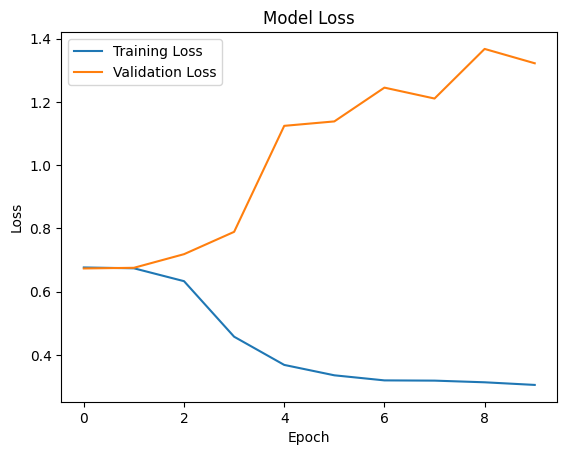

20/20 [==============================] - 3s 132ms/step - loss: 1.2690 - accuracy: 0.5499
Test Accuracy: 54.99%


=============  NEW CHAT GPT 3.5 CNN-LSTM   =============== 


/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 34)]                 0         []                            
                                                                                                  
 embedding_16 (Embedding)    (None, 34, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 conv1d_18 (Conv1D)          (None, 32, 128)              49280     ['embedding_16[0][0]']        
                                                                                                  
 max_pooling1d_18 (MaxPooli  (None, 10, 128)              0         ['conv1d_18[0][0]']           
 ng1D)                                                                                     

2023-08-16 20:28:35.858141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:28:37.787608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:28:38.827720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:28:43.950575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:28:46.081316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 0.6892 - accuracy: 0.5460

2023-08-16 20:29:15.913079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:29:16.904248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:29:17.697903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 49s 487ms/step - loss: 0.6892 - accuracy: 0.5460 - val_loss: 0.6780 - val_accuracy: 0.5932
Epoch 2/10
67/67 [==============================] - 10s 142ms/step - loss: 0.6877 - accuracy: 0.5629 - val_loss: 0.6824 - val_accuracy: 0.5970
Epoch 3/10
67/67 [==============================] - 8s 119ms/step - loss: 0.6791 - accuracy: 0.5724 - val_loss: 0.6955 - val_accuracy: 0.5989
Epoch 4/10
67/67 [==============================] - 5s 77ms/step - loss: 0.5716 - accuracy: 0.6709 - val_loss: 0.7702 - val_accuracy: 0.5254
Epoch 5/10
67/67 [==============================] - 7s 97ms/step - loss: 0.4651 - accuracy: 0.7275 - val_loss: 0.9726 - val_accuracy: 0.5386
Epoch 6/10
67/67 [==============================] - 6s 86ms/step - loss: 0.4323 - accuracy: 0.7435 - val_loss: 1.2865 - val_accuracy: 0.5669
Epoch 7/10
67/67 [==============================] - 5s 77ms/step - loss: 0.4272 - accuracy: 0.7421 - val_loss: 1.0928 - val_accuracy: 0.5537
Epoch 8/10
67/67 [=

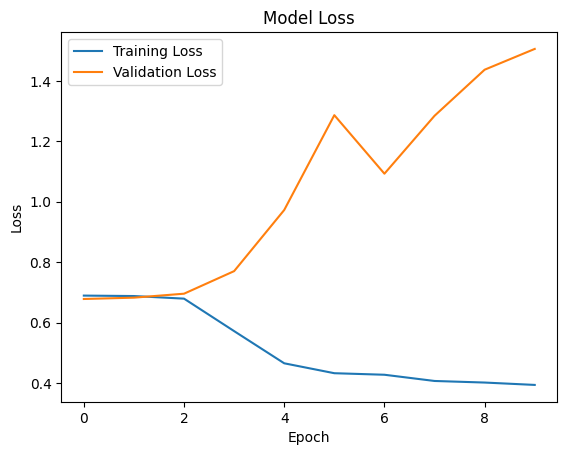

21/21 [==============================] - 3s 170ms/step - loss: 1.2229 - accuracy: 0.5204
Test Accuracy: 52.04%


In [286]:
print("=============  HOT CHAT GPT 3.5 CNN-LSTM  =============== \n")
model_CNN_LSTM(hot_chatgpt_ret)
print("\n\n=============  NEW CHAT GPT 3.5 CNN-LSTM   =============== ")
model_CNN_LSTM(new_chatgpt_ret)

In [287]:
def model_CNN_LSTM_vader(df, max_words=10000):
    df['text'] = df['text'].astype(str)

    # One-hot encoding for 'ticker' column
    one_hot_encoder = OneHotEncoder(sparse=False)
    ticker_one_hot = one_hot_encoder.fit_transform(df[['ticker']])
    
    # Separate features and target variable
    X_text = df['text']
    X_ticker = ticker_one_hot
    X_neg = df['neg'].values.reshape(-1, 1)
    X_neu = df['neu'].values.reshape(-1, 1)
    X_pos = df['pos'].values.reshape(-1, 1)
    X_compound = df['compound'].values.reshape(-1, 1)
    y = (df['ret'] > 0).astype(int)

    # Split the data into training and testing sets
    X_train_text, X_test_text, X_train_ticker, X_test_ticker, X_train_neg, X_test_neg, X_train_neu, X_test_neu, X_train_pos, X_test_pos, X_train_compound, X_test_compound, y_train, y_test = train_test_split(X_text, X_ticker, X_neg, X_neu, X_pos, X_compound, y, test_size=0.2, random_state=42)

    # Tokenize and pad the 'text' column for training and testing sets
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train_text)
    train_text_sequences = tokenizer.texts_to_sequences(X_train_text)
    test_text_sequences = tokenizer.texts_to_sequences(X_test_text)
    max_sequence_length = max(len(s) for s in train_text_sequences + test_text_sequences)
    train_text_padded = pad_sequences(train_text_sequences, maxlen=max_sequence_length)
    test_text_padded = pad_sequences(test_text_sequences, maxlen=max_sequence_length)

    # Text Input (CNN followed by LSTM)
    text_input = Input(shape=(max_sequence_length,), name='text_input')
    text_embedding = Embedding(input_dim=max_words, output_dim=128)(text_input)
    text_conv1 = Conv1D(128, 3, activation='relu')(text_embedding)
    text_pool1 = MaxPooling1D(3)(text_conv1)
    text_conv2 = Conv1D(128, 3, activation='relu')(text_pool1)
    text_pool2 = MaxPooling1D(3)(text_conv2)
    text_lstm1 = LSTM(128, return_sequences=True)(text_pool2)
    text_lstm2 = LSTM(64)(text_lstm1)  # Additional LSTM layer
    text_dense = Dense(32, activation='relu')(text_lstm2)

    # Ticker Input (numeric)
    ticker_input_shape = X_ticker.shape[1]
    ticker_input = Input(shape=(ticker_input_shape,), name='ticker_input')
    ticker_dense = Dense(16, activation='relu')(ticker_input)

    # Sentiment Scores Input (numeric)
    neg_input = Input(shape=(1,), name='neg_input')
    neu_input = Input(shape=(1,), name='neu_input')
    pos_input = Input(shape=(1,), name='pos_input')
    compound_input = Input(shape=(1,), name='compound_input')

    # Concatenate sentiment scores
    sentiment_scores = concatenate([neg_input, neu_input, pos_input, compound_input])
    sentiment_dense = Dense(16, activation='relu')(sentiment_scores)

    # Concatenate all inputs
    concatenated = concatenate([text_dense, ticker_dense, sentiment_dense])
    dense_1 = Dense(64, activation='relu')(concatenated)
    output = Dense(1, activation='sigmoid')(dense_1)

    # Build and compile the model
    model = Model(inputs=[text_input, ticker_input, neg_input, neu_input, pos_input, compound_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Model summary
    model.summary()

    # Train the model
    history = model.fit(
        {'text_input': train_text_padded, 'ticker_input': X_train_ticker, 'neg_input': X_train_neg, 'neu_input': X_train_neu, 'pos_input': X_train_pos, 'compound_input': X_train_compound},
        y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.2
    )

    # Plot the loss (you'll need to define or import a function to do this)
    plot_loss(history)

    # Evaluate the model
    loss, accuracy = model.evaluate(
        {'text_input': test_text_padded, 'ticker_input': X_test_ticker, 'neg_input': X_test_neg, 'neu_input': X_test_neu, 'pos_input': X_test_pos, 'compound_input': X_test_compound},
        y_test
    )
    print("Test Accuracy: {:.2f}%".format(accuracy * 100))


=============  HOT VADER CNN-LSTM  =============== 



/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 32)]                 0         []                            
                                                                                                  
 embedding_17 (Embedding)    (None, 32, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 conv1d_20 (Conv1D)          (None, 30, 128)              49280     ['embedding_17[0][0]']        
                                                                                                  
 max_pooling1d_20 (MaxPooli  (None, 10, 128)              0         ['conv1d_20[0][0]']           
 ng1D)                                                                                     

2023-08-16 20:30:46.759963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:30:49.525716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:30:51.377309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:30:57.673484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:30:59.613501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.5761

2023-08-16 20:32:01.398371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:32:03.386873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:32:04.599918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 88s 1s/step - loss: 0.6842 - accuracy: 0.5761 - val_loss: 0.6692 - val_accuracy: 0.6126
Epoch 2/10
64/64 [==============================] - 14s 204ms/step - loss: 0.6734 - accuracy: 0.6057 - val_loss: 0.6696 - val_accuracy: 0.6126
Epoch 3/10
64/64 [==============================] - 9s 133ms/step - loss: 0.6702 - accuracy: 0.6057 - val_loss: 0.6688 - val_accuracy: 0.6126
Epoch 4/10
64/64 [==============================] - 6s 98ms/step - loss: 0.6675 - accuracy: 0.6102 - val_loss: 0.6891 - val_accuracy: 0.5810
Epoch 5/10
64/64 [==============================] - 7s 104ms/step - loss: 0.6080 - accuracy: 0.6734 - val_loss: 0.7550 - val_accuracy: 0.5573
Epoch 6/10
64/64 [==============================] - 5s 78ms/step - loss: 0.4963 - accuracy: 0.7446 - val_loss: 0.9011 - val_accuracy: 0.5514
Epoch 7/10
64/64 [==============================] - 7s 105ms/step - loss: 0.4030 - accuracy: 0.7866 - val_loss: 1.1677 - val_accuracy: 0.5316
Epoch 8/10
64/64 [==

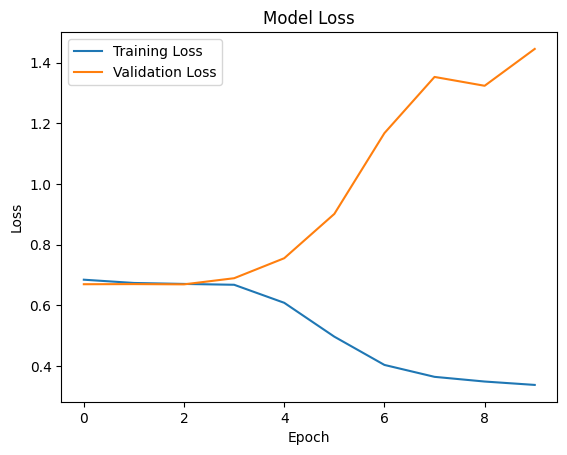

20/20 [==============================] - 3s 139ms/step - loss: 1.2706 - accuracy: 0.5387
Test Accuracy: 53.87%


=============  NEW VADER CNN-LSTM   =============== 


/opt/homebrew/anaconda3/envs/stocks/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 32)]                 0         []                            
                                                                                                  
 embedding_18 (Embedding)    (None, 32, 128)              1280000   ['text_input[0][0]']          
                                                                                                  
 conv1d_22 (Conv1D)          (None, 30, 128)              49280     ['embedding_18[0][0]']        
                                                                                                  
 max_pooling1d_22 (MaxPooli  (None, 10, 128)              0         ['conv1d_22[0][0]']           
 ng1D)                                                                                     

2023-08-16 20:33:20.512411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:33:22.724882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:33:23.997710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:33:28.816318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:33:30.947624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 0.6913 - accuracy: 0.5437

2023-08-16 20:34:01.260171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:34:02.393283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 20:34:03.432325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 51s 529ms/step - loss: 0.6913 - accuracy: 0.5437 - val_loss: 0.6814 - val_accuracy: 0.5872
Epoch 2/10
67/67 [==============================] - 48s 716ms/step - loss: 0.6894 - accuracy: 0.5446 - val_loss: 0.6844 - val_accuracy: 0.5816
Epoch 3/10
67/67 [==============================] - 16s 237ms/step - loss: 0.6271 - accuracy: 0.6095 - val_loss: 0.7489 - val_accuracy: 0.5497
Epoch 4/10
67/67 [==============================] - 9s 137ms/step - loss: 0.4600 - accuracy: 0.7246 - val_loss: 0.9640 - val_accuracy: 0.5553
Epoch 5/10
67/67 [==============================] - 9s 128ms/step - loss: 0.3786 - accuracy: 0.7693 - val_loss: 1.2690 - val_accuracy: 0.5516
Epoch 6/10
67/67 [==============================] - 8s 125ms/step - loss: 0.3503 - accuracy: 0.7928 - val_loss: 1.5327 - val_accuracy: 0.5553
Epoch 7/10
67/67 [==============================] - 7s 97ms/step - loss: 0.3475 - accuracy: 0.7904 - val_loss: 1.2295 - val_accuracy: 0.5478
Epoch 8/10
67/6

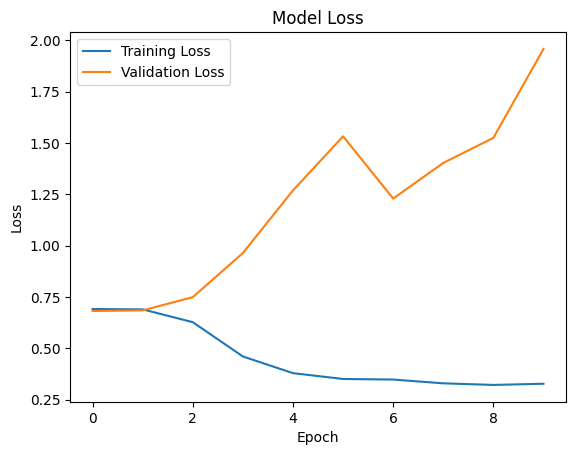

21/21 [==============================] - 3s 150ms/step - loss: 1.7985 - accuracy: 0.5330
Test Accuracy: 53.30%


In [288]:
print("=============  HOT VADER CNN-LSTM  =============== \n")
model_CNN_LSTM_vader(hot_vader_ret)
print("\n\n=============  NEW VADER CNN-LSTM   =============== ")
model_CNN_LSTM_vader(new_vader_ret)